In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
# ============================================================================
# DATA DOWNLOAD FROM OANDA API
# ============================================================================

import requests
import os
import time
from dotenv import load_dotenv
from datetime import datetime

# Ensure data directory exists
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

print("="*80)
print("DATA DOWNLOAD FROM OANDA API")
print("="*80)

# Load environment variables from .env file
load_dotenv()

# Get OANDA API key and Account ID from environment variables
OANDA_API_KEY = os.getenv("OANDA_API_KEY")
OANDA_ACCOUNT_ID = os.getenv("OANDA_ACCOUNT_ID")

if not OANDA_API_KEY or not OANDA_ACCOUNT_ID:
    print("\n❌ FATAL ERROR: OANDA credentials not found in .env file.")
    print("Please create a .env file with:")
    print("  OANDA_API_KEY=your_api_key")
    print("  OANDA_ACCOUNT_ID=your_account_id")
    raise ValueError("OANDA credentials not found")
else:
    print("✅ OANDA credentials loaded successfully.")

# OANDA API settings
API_URL = "https://api-fxpractice.oanda.com/v3/instruments/{instrument}/candles"
HEADERS = {
    "Authorization": f"Bearer {OANDA_API_KEY}",
    "Content-Type": "application/json"
}

INSTRUMENTS = {"BCO_USD": "BRENT", "WTICO_USD": "WTI"}

def download_instrument_data(instrument, series_name, granularity, start_date, end_date, max_retries=5, initial_delay=3, request_delay=1.5):
    """Download hourly data for a single instrument from OANDA API with retry logic"""
    print(f"\n⬇️ Starting download for {series_name} ({instrument})...")
    all_candles = []
    
    current_start_str = pd.to_datetime(start_date).isoformat().replace('+00:00', 'Z')
    end_dt = pd.to_datetime(end_date).tz_localize('UTC')
    
    last_received_timestamp = None

    while True:
        params = {
            "granularity": granularity,
            "from": current_start_str,
            "price": "M",
            "count": 5000
        }
        
        # Retry logic for handling 502 errors and other transient failures
        retry_count = 0
        success = False
        response = None
        was_retry = False
        
        while retry_count < max_retries and not success:
            try:
                response = requests.get(API_URL.format(instrument=instrument), headers=HEADERS, params=params, timeout=30)
                response.raise_for_status()
                success = True
                # If this was a retry, add extra delay after success to let API recover
                if was_retry:
                    print(f"   ✅ Request succeeded after retry. Waiting {request_delay * 2} seconds before continuing...")
                    time.sleep(request_delay * 2)
            except requests.exceptions.HTTPError as e:
                if response and response.status_code == 502:
                    retry_count += 1
                    was_retry = True
                    if retry_count < max_retries:
                        delay = initial_delay * (2 ** (retry_count - 1))  # Exponential backoff
                        print(f"   ⚠️  502 Bad Gateway error. Retrying in {delay} seconds... (Attempt {retry_count}/{max_retries})")
                        time.sleep(delay)
                    else:
                        print(f"   ❌ HTTP Request failed after {max_retries} retries: {e}")
                        return None
                else:
                    print(f"   ❌ HTTP Request failed: {e}")
                    return None
            except requests.exceptions.RequestException as e:
                retry_count += 1
                was_retry = True
                if retry_count < max_retries:
                    delay = initial_delay * (2 ** (retry_count - 1))
                    print(f"   ⚠️  Request error: {e}. Retrying in {delay} seconds... (Attempt {retry_count}/{max_retries})")
                    time.sleep(delay)
                else:
                    print(f"   ❌ HTTP Request failed after {max_retries} retries: {e}")
                    return None
        
        if not success:
            return None
            
        data = response.json()
        candles = data.get('candles', [])
        
        if not candles:
            print(f"   ✅ No more data returned. Download complete.")
            break
            
        last_candle_time = pd.to_datetime(candles[-1]['time'])
        print(f"   Retrieved {len(candles)} candles. Latest timestamp: {last_candle_time}")
        
        # If the latest candle's time is the same as the last one we saw, we're stuck.
        if last_received_timestamp and last_candle_time == last_received_timestamp:
            print(f"   ✅ No new data since last fetch. Download complete.")
            all_candles.extend(candles)  # Add the final set of candles
            break
        
        all_candles.extend(candles)
        last_received_timestamp = last_candle_time

        if last_candle_time >= end_dt:
            print(f"   ✅ Reached end date. Download complete.")
            break
            
        current_start_str = candles[-1]['time']
        
        # Delay between requests to avoid rate limiting and reduce 502 errors
        # Increased delay to be more gentle on the API
        time.sleep(request_delay)
        
    if not all_candles:
        print(f"   ⚠️ Warning: No data was returned for {instrument}.")
        return None

    # Process the collected data into a clean DataFrame
    try:
        processed_candles = [
            {'time': candle['time'], 'price': float(candle['mid']['c'])}
            for candle in all_candles
        ]
        df = pd.DataFrame(processed_candles)
        
        # Drop any potential duplicates based on time and set the index
        df = df.drop_duplicates(subset='time', keep='first')
        df['date'] = pd.to_datetime(df['time'])
        df = df.set_index('date')

        # Finalize the DataFrame structure
        df = df[['price']].rename(columns={'price': f'{series_name}_price'})
        
        file_path = f"data/{series_name.lower()}_hourly_price.csv"
        df.to_csv(file_path)
        print(f"   💾 Saved {len(df)} records to {file_path}")
        print(f"   📊 Date range: {df.index.min()} to {df.index.max()}")
        
        return df
    except Exception as e:
        print(f"   ❌ Error processing data: {e}")
        return None

# Main download process with resume capability
initial_start_date = "2019-01-01"
end_date = datetime.utcnow().strftime("%Y-%m-%d")
overlap_days = 3  # Download from 3 days before last data point to ensure completeness

print(f"\n{'='*80}")
print("CHECKING EXISTING DATA")
print(f"{'='*80}")

# Check for existing data files
brent_file = Path("data/brent_hourly_price.csv")
wti_file = Path("data/wti_hourly_price.csv")
combined_file = Path("data/brent_wti_hourly_prices.csv")

existing_brent_df = None
existing_wti_df = None
existing_combined_df = None

# Load existing data if available
if brent_file.exists():
    try:
        existing_brent_df = pd.read_csv(brent_file, parse_dates=['date'], index_col='date')
        print(f"✅ Found existing BRENT data: {len(existing_brent_df)} records")
        print(f"   Date range: {existing_brent_df.index.min()} to {existing_brent_df.index.max()}")
    except Exception as e:
        print(f"⚠️  Could not load existing BRENT data: {e}")

if wti_file.exists():
    try:
        existing_wti_df = pd.read_csv(wti_file, parse_dates=['date'], index_col='date')
        print(f"✅ Found existing WTI data: {len(existing_wti_df)} records")
        print(f"   Date range: {existing_wti_df.index.min()} to {existing_wti_df.index.max()}")
    except Exception as e:
        print(f"⚠️  Could not load existing WTI data: {e}")

if combined_file.exists():
    try:
        existing_combined_df = pd.read_csv(combined_file, parse_dates=['date'], index_col='date')
        print(f"✅ Found existing combined data: {len(existing_combined_df)} records")
        print(f"   Date range: {existing_combined_df.index.min()} to {existing_combined_df.index.max()}")
    except Exception as e:
        print(f"⚠️  Could not load existing combined data: {e}")

# Determine start dates for each instrument (3 days before last data point)
brent_start_date = initial_start_date
wti_start_date = initial_start_date

if existing_brent_df is not None and len(existing_brent_df) > 0:
    last_brent_date = existing_brent_df.index.max()
    # Start from 3 days before last data point
    brent_start_date = (last_brent_date - pd.Timedelta(days=overlap_days)).strftime("%Y-%m-%d")
    print(f"\n📅 BRENT: Will resume from {brent_start_date} (3 days before last data: {last_brent_date.strftime('%Y-%m-%d')})")
else:
    print(f"\n📅 BRENT: Will start from beginning: {brent_start_date}")

if existing_wti_df is not None and len(existing_wti_df) > 0:
    last_wti_date = existing_wti_df.index.max()
    # Start from 3 days before last data point
    wti_start_date = (last_wti_date - pd.Timedelta(days=overlap_days)).strftime("%Y-%m-%d")
    print(f"📅 WTI: Will resume from {wti_start_date} (3 days before last data: {last_wti_date.strftime('%Y-%m-%d')})")
else:
    print(f"📅 WTI: Will start from beginning: {wti_start_date}")

print(f"\n{'='*80}")
print("DOWNLOADING NEW DATA")
print(f"{'='*80}")
print(f"Target end date: {end_date}")
print("Note: Using delays between requests to avoid API rate limiting and 502 errors.")
print()

# Download new data
brent_new_df = download_instrument_data("BCO_USD", "BRENT", "H1", brent_start_date, end_date)

# Add delay between downloading different instruments to avoid overwhelming the API
if brent_new_df is not None:
    print("\n   ⏳ Waiting 3 seconds before downloading next instrument...")
    time.sleep(3)

wti_new_df = download_instrument_data("WTICO_USD", "WTI", "H1", wti_start_date, end_date)

# Merge new data with existing data
print(f"\n{'='*80}")
print("MERGING DATA")
print(f"{'='*80}")

# Merge BRENT data
if brent_new_df is not None:
    if existing_brent_df is not None:
        # Combine existing and new data, remove duplicates, sort
        brent_df = pd.concat([existing_brent_df, brent_new_df])
        brent_df = brent_df[~brent_df.index.duplicated(keep='last')].sort_index()
        print(f"✅ BRENT: Merged {len(existing_brent_df)} existing + {len(brent_new_df)} new = {len(brent_df)} total records")
    else:
        brent_df = brent_new_df
        print(f"✅ BRENT: Saved {len(brent_df)} new records (no existing data)")
    
    # Save BRENT data
    brent_file_path = "data/brent_hourly_price.csv"
    brent_df.to_csv(brent_file_path)
    print(f"   💾 Saved to {brent_file_path}")
else:
    brent_df = existing_brent_df
    if brent_df is not None:
        print(f"⚠️  BRENT: No new data downloaded, using existing {len(brent_df)} records")

# Merge WTI data
if wti_new_df is not None:
    if existing_wti_df is not None:
        # Combine existing and new data, remove duplicates, sort
        wti_df = pd.concat([existing_wti_df, wti_new_df])
        wti_df = wti_df[~wti_df.index.duplicated(keep='last')].sort_index()
        print(f"✅ WTI: Merged {len(existing_wti_df)} existing + {len(wti_new_df)} new = {len(wti_df)} total records")
    else:
        wti_df = wti_new_df
        print(f"✅ WTI: Saved {len(wti_df)} new records (no existing data)")
    
    # Save WTI data
    wti_file_path = "data/wti_hourly_price.csv"
    wti_df.to_csv(wti_file_path)
    print(f"   💾 Saved to {wti_file_path}")
else:
    wti_df = existing_wti_df
    if wti_df is not None:
        print(f"⚠️  WTI: No new data downloaded, using existing {len(wti_df)} records")

# Merge combined data
if wti_df is not None and brent_df is not None:
    print(f"\n{'─'*80}")
    print("Creating combined dataset...")
    combined_df = pd.merge(wti_df, brent_df, left_index=True, right_index=True, how='outer').sort_index()
    
    combined_file_path = "data/brent_wti_hourly_prices.csv"
    combined_df.to_csv(combined_file_path)
    print(f"✅ Successfully merged and saved hourly data to {combined_file_path}")
    print(f"\n📊 Final Data Summary:")
    print(f"   Shape: {combined_df.shape}")
    print(f"   Date range: {combined_df.index.min()} to {combined_df.index.max()}")
    print(f"   BRENT records: {combined_df['BRENT_price'].notna().sum()}")
    print(f"   WTI records: {combined_df['WTI_price'].notna().sum()}")
    print(f"\n{'='*80}")
    print("DATA DOWNLOAD COMPLETE")
    print("="*80)
elif wti_df is not None or brent_df is not None:
    print(f"\n{'─'*80}")
    print("⚠️  Partial data available:")
    if wti_df is not None:
        print(f"   ✅ WTI data: {len(wti_df)} records")
        print(f"      Date range: {wti_df.index.min()} to {wti_df.index.max()}")
    if brent_df is not None:
        print(f"   ✅ BRENT data: {len(brent_df)} records")
        print(f"      Date range: {brent_df.index.min()} to {brent_df.index.max()}")
    print("\n   💡 Tip: Try running the download again to get the missing data.")
    print("   The API may have temporary issues (502 errors). The retry logic will attempt")
    print("   to recover automatically, but you may need to run the cell again.")
    print("   The script will automatically resume from where it left off.")
else:
    print(f"\n{'─'*80}")
    print("❌ Data download failed for all instruments.")
    print("Please check your API credentials and network connection.")
    print("If you're getting 502 errors, the OANDA API may be experiencing issues.")
    print("Try running this cell again in a few minutes.")

DATA DOWNLOAD FROM OANDA API
✅ OANDA credentials loaded successfully.

CHECKING EXISTING DATA
✅ Found existing BRENT data: 40253 records
   Date range: 2019-01-02 01:00:00+00:00 to 2026-02-13 21:00:00+00:00
✅ Found existing WTI data: 42096 records
   Date range: 2019-01-01 23:00:00+00:00 to 2026-02-13 21:00:00+00:00
✅ Found existing combined data: 43592 records
   Date range: 2019-01-01 23:00:00+00:00 to 2026-02-13 21:00:00+00:00

📅 BRENT: Will resume from 2026-02-10 (3 days before last data: 2026-02-13)
📅 WTI: Will resume from 2026-02-10 (3 days before last data: 2026-02-13)

DOWNLOADING NEW DATA
Target end date: 2026-02-14
Note: Using delays between requests to avoid API rate limiting and 502 errors.


⬇️ Starting download for BRENT (BCO_USD)...
   Retrieved 83 candles. Latest timestamp: 2026-02-13 21:00:00+00:00
   Retrieved 1 candles. Latest timestamp: 2026-02-13 21:00:00+00:00
   ✅ No new data since last fetch. Download complete.
   💾 Saved 83 records to data/brent_hourly_price.cs


Aggregating hourly data to daily for returns calculation...
Hourly data points: 38757
Daily data points: 2026
Daily date range: 2019-01-02 01:00:00+00:00 to 2026-02-13 01:00:00+00:00

LABEL PERIODS DEFINED - MULTI-CONFLICT SCHEME

TRAINING PERIODS (2024-2025 only):
  Normal-Tense (2024-01-01 to 2025-02-13): High-tension normal before Iran pre-war
  Pre-War Early: 2025-02-13 to 2025-04-14
  Pre-War Close: 2025-04-14 to 2025-06-13
  War (Iran): 2025-06-13 to 2025-06-24
  Post-War Close: 2025-06-24 to 2025-08-23
  Post-War Late: 2025-08-23 to 2025-10-22
  Normal-Tense (2025-10-22 to 2025-12-31): High-tension normal after post-war period

TEST PERIODS (all other data):
  Normal (2019-01 to 2019-06): Pre-tension baseline test
  2019-Tension (2019-07 to 2020-01): Iran-Saudi tension escalation test (potential pre-war disrupted by COVID)
  Normal-COVID (2020-02 to 2021-09): COVID impact test
  Russia-Ukraine-Pre-War (2021-10-01 to 2022-02-23): Pre-war buildup test
  Russia-Ukraine-War (2022-0

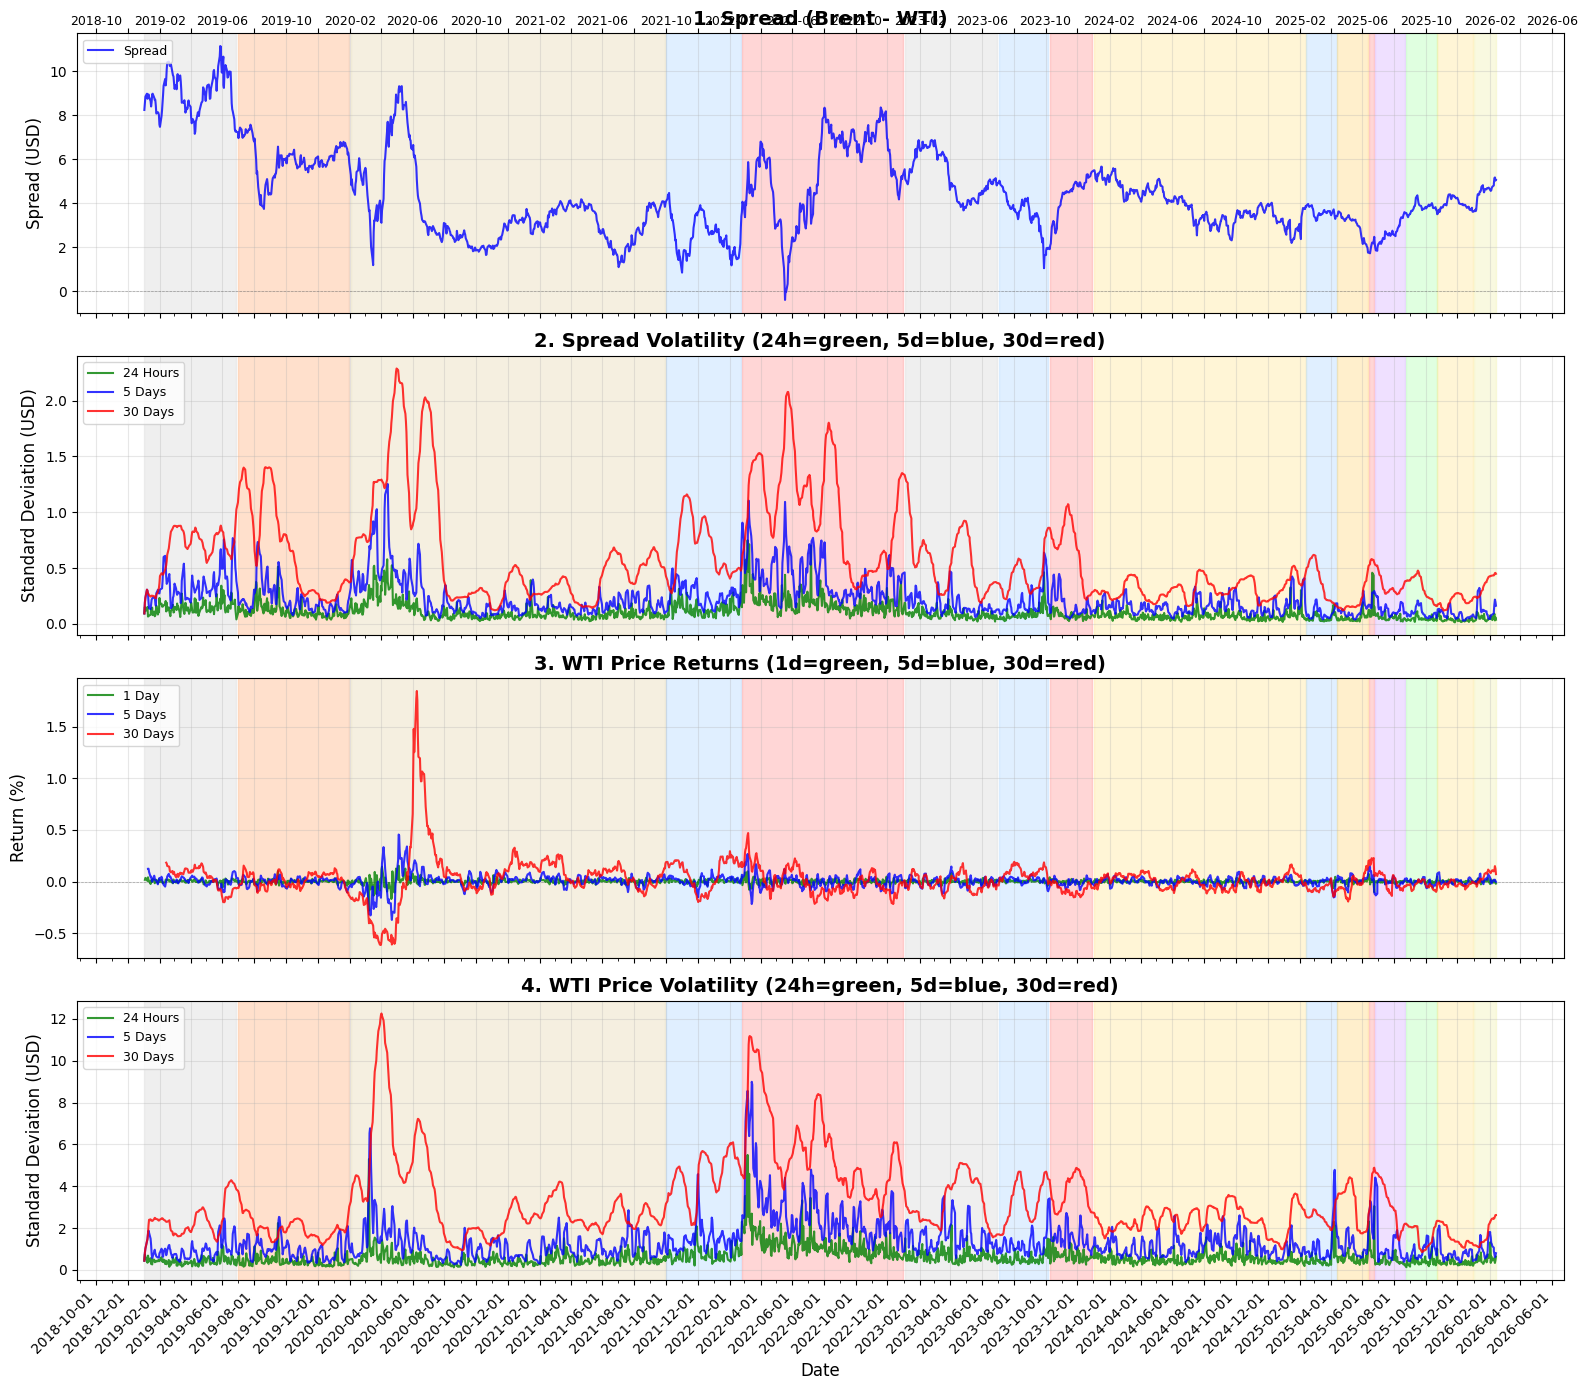


DATA PREPARATION COMPLETE

DataFrame shape: (2026, 16)

Feature columns:
  spread, spread_vol_24h, spread_vol_5d, spread_vol_30d, WTI_return_1d, WTI_return_5d, WTI_return_30d, WTI_price_vol_24h, WTI_price_vol_5d, WTI_price_vol_30d, WTI_abs_change, BRENT_abs_change

First few rows (showing key features and labels):
                       date  WTI_price  BRENT_price    spread  spread_vol_24h  \
0 2019-01-02 01:00:00+00:00  45.442429    53.683857  8.241429        0.093992   
1 2019-01-03 01:00:00+00:00  46.167476    54.748429  8.580952        0.150635   
2 2019-01-04 01:00:00+00:00  47.768905    56.618905  8.850000        0.119968   
3 2019-01-07 01:00:00+00:00  48.805048    57.784619  8.979571        0.122389   
4 2019-01-08 01:00:00+00:00  49.036238    57.786571  8.750333        0.151864   
5 2019-01-09 01:00:00+00:00  51.042190    59.911810  8.869619        0.066230   
6 2019-01-10 01:00:00+00:00  51.895143    60.844667  8.949524        0.068250   
7 2019-01-11 01:00:00+00:00  52.218

In [3]:
# ============================================================================
# DATA LOADING AND PREPARATION
# ============================================================================

# Load hourly data from 2019 onward (full dataset)
hourly_data_path = Path('data/brent_wti_hourly_prices.csv')
df_hourly = pd.read_csv(hourly_data_path, parse_dates=['date'])

# Filter data from 2019-01-01 to current (make timezone-aware to match data)
start_date = pd.Timestamp('2019-01-01', tz='UTC')
df = df_hourly[df_hourly['date'] >= start_date].copy()

# Remove rows where EITHER price is missing (we need both to calculate spread)
df = df.dropna(subset=['WTI_price', 'BRENT_price'], how='any')

# Sort by date to ensure proper calculation of rolling features
df = df.sort_values('date').reset_index(drop=True)

# ============================================================================
# FEATURE 1: SPREAD (Brent - WTI)
# ============================================================================
df['spread'] = df['BRENT_price'] - df['WTI_price']

# ============================================================================
# FEATURE 2: SPREAD VOLATILITY (24 hours, 5 days, 30 days)
# ============================================================================
# Since data is hourly: 24 hours = 24 periods, 5 days = 120 periods, 30 days = 720 periods
df['spread_vol_24h'] = df['spread'].rolling(window=24, min_periods=1).std()
df['spread_vol_5d'] = df['spread'].rolling(window=120, min_periods=1).std()  # 5 days = 120 hours
df['spread_vol_30d'] = df['spread'].rolling(window=720, min_periods=1).std()  # 30 days = 720 hours

# ============================================================================
# FEATURE 4: WTI PRICE VOLATILITY (24 hours, 5 days, 30 days)
# ============================================================================
# Calculate price volatility on hourly data BEFORE aggregation
# Price volatility calculated as standard deviation over rolling windows
df['WTI_price_vol_24h'] = df['WTI_price'].rolling(window=24, min_periods=1).std()
df['WTI_price_vol_5d'] = df['WTI_price'].rolling(window=120, min_periods=1).std()  # 5 days = 120 hours
df['WTI_price_vol_30d'] = df['WTI_price'].rolling(window=720, min_periods=1).std()  # 30 days = 720 hours

# ============================================================================
# AGGREGATE TO DAILY DATA (for returns calculation)
# ============================================================================
# Returns should be calculated on daily data, not hourly
# First aggregate hourly data to daily

print(f"\nAggregating hourly data to daily for returns calculation...")
print(f"Hourly data points: {len(df)}")

# Create date column for grouping (just the date, no time)
df['date_day'] = df['date'].dt.date

# Define aggregation strategy for each column
agg_dict = {
    # Prices: use mean of the day
    'WTI_price': 'mean',
    'BRENT_price': 'mean',
    'spread': 'mean',
    
    # Volatilities: mean of daily volatilities
    'spread_vol_24h': 'mean',
    'spread_vol_5d': 'mean',
    'spread_vol_30d': 'mean',
    'WTI_price_vol_24h': 'mean',
    'WTI_price_vol_5d': 'mean',
    'WTI_price_vol_30d': 'mean',
    
    # Date: keep first date of the day
    'date': 'first'
}

# Group by day and aggregate
df_daily = df.groupby('date_day').agg(agg_dict).reset_index()

# Convert date_day back to datetime for label creation
df_daily['date'] = pd.to_datetime(df_daily['date'])
df_daily = df_daily.sort_values('date').reset_index(drop=True)

print(f"Daily data points: {len(df_daily)}")
print(f"Daily date range: {df_daily['date'].min()} to {df_daily['date'].max()}")

# ============================================================================
# FEATURE 3: WTI PRICE RETURNS (1 day, 5 days, 30 days)
# ============================================================================
# Returns calculated on daily data as day-over-day percentage change
df_daily['WTI_return_1d'] = df_daily['WTI_price'].pct_change(periods=1)   # 1 day return
df_daily['WTI_return_5d'] = df_daily['WTI_price'].pct_change(periods=5)   # 5 day return
df_daily['WTI_return_30d'] = df_daily['WTI_price'].pct_change(periods=30) # 30 day return

# Replace df with daily aggregated data
df = df_daily.drop(columns=['date_day']).copy()

# ============================================================================
# FEATURE 5: ABSOLUTE PRICE CHANGES (1-day)
# ============================================================================
# Absolute price change: magnitude of price movement in dollar terms
# This is a different measure of volatility - captures dollar impact, not percentage
# Calculate on daily aggregated data (after returns are calculated)
df['WTI_abs_change'] = df['WTI_price'].diff(periods=1).abs()   # 1 day absolute change
df['BRENT_abs_change'] = df['BRENT_price'].diff(periods=1).abs()   # 1 day absolute change

# Note: WTI_price_vol was calculated on hourly data and aggregated to daily
# Returns are now calculated on daily data (proper day-over-day returns)

# ============================================================================
# CREATE DATE-BASED LABELS - MULTI-CONFLICT SCHEME
# ============================================================================
# New comprehensive labeling scheme:
# 
# TRAINING DATA (2024-2025 only):
# - 2024-2025: Iran-related war periods (Pre-War Early/Close, War, Post-War Close/Late, Normal-Tense)
#
# TEST DATA (everything else):
# - 2019-01-01 to 2019-06-30: Normal (Pre-tension baseline test)
# - 2019-07-01 to 2020-01-31: 2019-Tension (Iran-Saudi tension escalation test)
# - 2020-02-01 to 2021-09-30: Normal-COVID (COVID impact test)
# - 2021-10-01 to 2022-02-23: Russia-Ukraine-Pre-War (Test)
# - 2022-02-24 to 2022-12-31: Russia-Ukraine-War (Test)
# - 2023-01-01 to 2023-06-30: Normal (Post-Russia-Ukraine baseline test)
# - 2023-07-01 to 2023-10-06: Israel-Hamas-Pre-War (Test)
# - 2023-10-07 to 2023-12-31: Israel-Hamas-War (Test)
# - 2026-01-01 onwards: Unlabeled (Future test data)

# ============================================================================
# IRAN-RELATED WAR PERIODS (2024-2025)
# ============================================================================
war_start = pd.Timestamp('2025-06-13', tz='UTC')
war_end = pd.Timestamp('2025-06-24', tz='UTC')

# Define time periods relative to Iran war
pre_war_early_start = war_start - pd.Timedelta(days=120)  # ~4 months before
pre_war_early_end = war_start - pd.Timedelta(days=60)     # ~2 months before
pre_war_close_start = war_start - pd.Timedelta(days=60)   # ~2 months before
pre_war_close_end = war_start                              # Up to war start

post_war_close_start = war_end                             # From war end
post_war_close_end = war_end + pd.Timedelta(days=60)       # ~2 months after
post_war_late_start = war_end + pd.Timedelta(days=60)      # ~2 months after
post_war_late_end = war_end + pd.Timedelta(days=120)       # ~4 months after

# ============================================================================
# KEY DATES
# ============================================================================
label_cutoff_date = pd.Timestamp('2026-01-01', tz='UTC')      # Start of unlabeled period

# ============================================================================
# INITIALIZE ALL LABELS
# ============================================================================
df['label'] = 'Normal'  # Default

# ============================================================================
# TEST PERIODS (Everything except 2024-2025)
# ============================================================================
# 2019-01-01 to 2019-06-30: Normal (Pre-tension baseline test - first half 2019)
mask_normal_2019_h1 = (df['date'] >= pd.Timestamp('2019-01-01', tz='UTC')) & \
                       (df['date'] <= pd.Timestamp('2019-06-30', tz='UTC'))
df.loc[mask_normal_2019_h1, 'label'] = 'Normal'

# 2019-07-01 to 2020-01-31: 2019-Tension (Iran-Saudi tension escalation test)
# Includes: Tanker attacks, Saudi refinery attack (Sep 14), Soleimani killing (Jan 3, 2020)
# This was a potential pre-war period disrupted by COVID
mask_2019_tension = (df['date'] >= pd.Timestamp('2019-07-01', tz='UTC')) & \
                    (df['date'] <= pd.Timestamp('2020-01-31', tz='UTC'))
df.loc[mask_2019_tension, 'label'] = '2019-Tension'

# 2020-02-01 to 2021-09-30: Normal-COVID Period (COVID impact test)
# Note: Late 2021 (Oct-Dec) is labeled as Russia-Ukraine-Pre-War
mask_covid = (df['date'] >= pd.Timestamp('2020-02-01', tz='UTC')) & \
             (df['date'] < pd.Timestamp('2021-10-01', tz='UTC'))
df.loc[mask_covid, 'label'] = 'Normal-COVID'

# 2023-01-01 to 2023-06-30: Post-Russia-Ukraine Normal (Secondary baseline)
mask_normal_2023_h1 = (df['date'] >= pd.Timestamp('2023-01-01', tz='UTC')) & \
                      (df['date'] <= pd.Timestamp('2023-06-30', tz='UTC'))
df.loc[mask_normal_2023_h1, 'label'] = 'Normal'

# Note: Data now starts from 2019-01-01, so no 2018 test period

# ============================================================================
# TEST PERIOD 2: 2020-2021 is labeled as Normal-COVID (handled above)
# ============================================================================
# 2020-2021 is labeled as Normal-COVID (2 years of COVID impact)

# ============================================================================
# TEST PERIOD 3: 2021-2022 (Russia-Ukraine War)
# ============================================================================
# Pre-war buildup (Late 2021 - Feb 23, 2022)
# Starting from October 2021 when tensions began to escalate significantly
mask_ru_pre_war = (df['date'] >= pd.Timestamp('2021-10-01', tz='UTC')) & \
                  (df['date'] < pd.Timestamp('2022-02-24', tz='UTC'))
df.loc[mask_ru_pre_war, 'label'] = 'Russia-Ukraine-Pre-War'

# War period (Feb 24 - Dec 31, 2022)
mask_ru_war = (df['date'] >= pd.Timestamp('2022-02-24', tz='UTC')) & \
              (df['date'] <= pd.Timestamp('2022-12-31', tz='UTC'))
df.loc[mask_ru_war, 'label'] = 'Russia-Ukraine-War'

# ============================================================================
# TEST PERIOD 4: 2023 Jul-Dec (Israel-Hamas War)
# ============================================================================
# Pre-war buildup (Jul 1 - Oct 6, 2023)
mask_im_pre_war = (df['date'] >= pd.Timestamp('2023-07-01', tz='UTC')) & \
                  (df['date'] < pd.Timestamp('2023-10-07', tz='UTC'))
df.loc[mask_im_pre_war, 'label'] = 'Israel-Hamas-Pre-War'

# War period (Oct 7 - Dec 31, 2023)
mask_im_war = (df['date'] >= pd.Timestamp('2023-10-07', tz='UTC')) & \
              (df['date'] <= pd.Timestamp('2023-12-31', tz='UTC'))
df.loc[mask_im_war, 'label'] = 'Israel-Hamas-War'

# ============================================================================
# TRAINING PERIOD: 2024-2025 (Iran-Related War)
# ============================================================================
# Normal-Tense (2024 before Iran pre-war - adjust start date as needed)
mask_normal_tense = (df['date'] >= pd.Timestamp('2024-01-01', tz='UTC')) & \
                    (df['date'] < pre_war_early_start) & \
                    (df['date'] < label_cutoff_date)
df.loc[mask_normal_tense, 'label'] = 'Normal-Tense'

# Iran-related war periods (these take precedence over Normal-Tense)
# Pre-War Early: 2-4 months before war
mask_pre_war_early = (df['date'] >= pre_war_early_start) & \
                     (df['date'] < pre_war_early_end) & \
                     (df['date'] < label_cutoff_date)
df.loc[mask_pre_war_early, 'label'] = 'Pre-War Early'

# Pre-War Close: 2 months before war
mask_pre_war_close = (df['date'] >= pre_war_close_start) & \
                     (df['date'] < war_start) & \
                     (df['date'] < label_cutoff_date)
df.loc[mask_pre_war_close, 'label'] = 'Pre-War Close'

# War period
mask_war = (df['date'] >= war_start) & \
           (df['date'] <= war_end) & \
           (df['date'] < label_cutoff_date)
df.loc[mask_war, 'label'] = 'War'  # Iran-related war

# Post-War Close: 2 months after war
mask_post_war_close = (df['date'] > war_end) & \
                     (df['date'] <= post_war_close_end) & \
                     (df['date'] < label_cutoff_date)
df.loc[mask_post_war_close, 'label'] = 'Post-War Close'

# Post-War Late: 2-4 months after war
mask_post_war_late = (df['date'] > post_war_close_end) & \
                    (df['date'] <= post_war_late_end) & \
                    (df['date'] < label_cutoff_date)
df.loc[mask_post_war_late, 'label'] = 'Post-War Late'

# Rest of 2025 after Post-War Late (2025-10-22 to 2025-12-31): Normal-Tense
# This covers the period after post-war stabilization but before 2026
mask_normal_tense_2025_end = (df['date'] > post_war_late_end) & \
                            (df['date'] < label_cutoff_date) & \
                            (df['date'] < pd.Timestamp('2026-01-01', tz='UTC'))
df.loc[mask_normal_tense_2025_end, 'label'] = 'Normal-Tense'

# ============================================================================
# UNLABELED PERIOD (2026+)
# ============================================================================
df.loc[df['date'] >= label_cutoff_date, 'label'] = 'Unlabeled'

# ============================================================================
# PRINT LABEL SUMMARY
# ============================================================================
print(f"\n{'='*80}")
print("LABEL PERIODS DEFINED - MULTI-CONFLICT SCHEME")
print(f"{'='*80}")
print(f"\nTRAINING PERIODS (2024-2025 only):")
print(f"  Normal-Tense (2024-01-01 to {pre_war_early_start.date()}): High-tension normal before Iran pre-war")
print(f"  Pre-War Early: {pre_war_early_start.date()} to {pre_war_early_end.date()}")
print(f"  Pre-War Close: {pre_war_close_start.date()} to {war_start.date()}")
print(f"  War (Iran): {war_start.date()} to {war_end.date()}")
print(f"  Post-War Close: {war_end.date()} to {post_war_close_end.date()}")
print(f"  Post-War Late: {post_war_close_end.date()} to {post_war_late_end.date()}")
print(f"  Normal-Tense ({post_war_late_end.date()} to 2025-12-31): High-tension normal after post-war period")
print(f"\nTEST PERIODS (all other data):")
print(f"  Normal (2019-01 to 2019-06): Pre-tension baseline test")
print(f"  2019-Tension (2019-07 to 2020-01): Iran-Saudi tension escalation test (potential pre-war disrupted by COVID)")
print(f"  Normal-COVID (2020-02 to 2021-09): COVID impact test")
print(f"  Russia-Ukraine-Pre-War (2021-10-01 to 2022-02-23): Pre-war buildup test")
print(f"  Russia-Ukraine-War (2022-02-24 to 2022-12-31): War period test")
print(f"  Normal (2023-01 to 2023-06): Post-Russia-Ukraine baseline test")
print(f"  Israel-Hamas-Pre-War (2023-07-01 to 2023-10-06): Pre-war buildup test")
print(f"  Israel-Hamas-War (2023-10-07 to 2023-12-31): War period test")
print(f"  Unlabeled (2026+): Future test data")

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================
print(f"\nTotal data points: {len(df)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\n{'='*80}")
print("FEATURE SUMMARY")
print(f"{'='*80}")

print(f"\n1. SPREAD (Brent - WTI):")
print(df['spread'].describe())

print(f"\n2. SPREAD VOLATILITY:")
print(f"  24 hours: mean={df['spread_vol_24h'].mean():.4f}, std={df['spread_vol_24h'].std():.4f}")
print(f"  5 days:   mean={df['spread_vol_5d'].mean():.4f}, std={df['spread_vol_5d'].std():.4f}")
print(f"  30 days:  mean={df['spread_vol_30d'].mean():.4f}, std={df['spread_vol_30d'].std():.4f}")

print(f"\n3. WTI PRICE RETURNS:")
print(f"  1 day:  mean={df['WTI_return_1d'].mean():.6f}, std={df['WTI_return_1d'].std():.6f}")
print(f"  5 days: mean={df['WTI_return_5d'].mean():.6f}, std={df['WTI_return_5d'].std():.6f}")
print(f"  30 days: mean={df['WTI_return_30d'].mean():.6f}, std={df['WTI_return_30d'].std():.6f}")

print(f"\n4. WTI PRICE VOLATILITY:")
print(f"  24 hours: mean={df['WTI_price_vol_24h'].mean():.4f}, std={df['WTI_price_vol_24h'].std():.4f}")
print(f"  5 days:   mean={df['WTI_price_vol_5d'].mean():.4f}, std={df['WTI_price_vol_5d'].std():.4f}")
print(f"  30 days:  mean={df['WTI_price_vol_30d'].mean():.4f}, std={df['WTI_price_vol_30d'].std():.4f}")

print(f"\n5. ABSOLUTE PRICE CHANGES (1-day):")
print(f"  WTI:   mean={df['WTI_abs_change'].mean():.4f}, std={df['WTI_abs_change'].std():.4f}")
print(f"  BRENT: mean={df['BRENT_abs_change'].mean():.4f}, std={df['BRENT_abs_change'].std():.4f}")
print(f"  Note: Absolute change measures volatility in dollar terms, not percentage")

print(f"\n{'='*80}")
print(f"Total features created: 12")
print(f"  - spread (1)")
print(f"  - spread_vol_24h, spread_vol_5d, spread_vol_30d (3)")
print(f"  - WTI_return_1d, WTI_return_5d, WTI_return_30d (3)")
print(f"  - WTI_price_vol_24h, WTI_price_vol_5d, WTI_price_vol_30d (3)")
print(f"  - WTI_abs_change, BRENT_abs_change (2)")
print(f"{'='*80}")

print(f"\n{'='*80}")
print("LABEL DISTRIBUTION")
print(f"{'='*80}")
label_counts = df['label'].value_counts().sort_index()
for label, count in label_counts.items():
    pct = count / len(df) * 100
    print(f"  {label:20s}: {count:6d} data points ({pct:5.2f}%)")
print(f"{'='*80}")

# ============================================================================
# VISUALIZATION
# ============================================================================

# Define background colors for labels (more visible, saturated colors)
# War periods use consistent colors across all conflicts for clarity
label_bg_colors = {
    # Training periods (2024-2025 only)
    'Normal-Tense': (1.0, 0.9, 0.6),     # Light orange/yellow for high-tension normal
    
    # Test periods
    'Normal': (0.85, 0.85, 0.85),       # Medium gray - baseline periods (test data)
    'Normal-COVID': (0.9, 0.85, 0.7),   # Light brown/yellow for COVID impact (2020-2021, 2 years)
    '2019-Tension': (1.0, 0.7, 0.5),     # Orange/red for 2019-Iran tension (Jul 2019 - Jan 2020) - distinct from Normal and Normal-COVID
    
    # Pre-War periods (consistent across all conflicts - light blue)
    'Pre-War Early': (0.7, 0.85, 1.0),   # Light blue
    'Pre-War Close': (1.0, 0.85, 0.5),   # Orange
    'Russia-Ukraine-Pre-War': (0.7, 0.85, 1.0),  # Same as Pre-War Early (light blue)
    'Israel-Hamas-Pre-War': (0.7, 0.85, 1.0),    # Same as Pre-War Early (light blue)
    
    # War periods (consistent across all conflicts - red)
    'War': (1.0, 0.6, 0.6),              # Red (Iran-related)
    'Russia-Ukraine-War': (1.0, 0.6, 0.6),        # Same as War (red)
    'Israel-Hamas-War': (1.0, 0.6, 0.6),          # Same as War (red)
    
    # Post-War periods (Iran-related only)
    'Post-War Close': (0.85, 0.7, 1.0),  # Purple
    'Post-War Late': (0.7, 1.0, 0.7),    # Green
    
    # Unlabeled
    'Unlabeled': (0.95, 0.95, 0.7)       # Light yellow for unlabeled data
}

# Define line colors for different time periods
period_colors = {
    '24h': 'green',
    '5d': 'blue',
    '30d': 'red',
    '1d': 'green',
    '24 Hours': 'green',
    '5 Days': 'blue',
    '30 Days': 'red',
    '1 Day': 'green'
}

# Function to add background shading for labels
def add_label_background(ax, dates, labels, color_map):
    """Add background shading for different label periods"""
    current_label = None
    segment_start = None
    
    for i, (date, label) in enumerate(zip(dates, labels)):
        if label != current_label:
            # End previous segment if it exists
            if current_label is not None and segment_start is not None:
                ax.axvspan(segment_start, dates.iloc[i-1] if i > 0 else dates.iloc[0], 
                          alpha=0.4, color=color_map.get(current_label, 'white'), zorder=0)
            # Start new segment
            current_label = label
            segment_start = date
    
    # Handle last segment
    if current_label is not None and segment_start is not None:
        ax.axvspan(segment_start, dates.iloc[-1], 
                  alpha=0.4, color=color_map.get(current_label, 'white'), zorder=0)

fig, axes = plt.subplots(4, 1, figsize=(16, 14), sharex=True)

# Plot 1: Spread
add_label_background(axes[0], df['date'], df['label'], label_bg_colors)
axes[0].plot(df['date'], df['spread'], linewidth=1.5, alpha=0.8, color='blue', label='Spread', zorder=3)
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=0.5)
axes[0].set_ylabel('Spread (USD)', fontsize=12)
axes[0].set_title('1. Spread (Brent - WTI)', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot 2: Spread Volatility (different colors for 24h, 5d, 30d)
add_label_background(axes[1], df['date'], df['label'], label_bg_colors)
periods_info = [('24h', '24 Hours'), ('5d', '5 Days'), ('30d', '30 Days')]
for period, period_label in periods_info:
    col_name = f'spread_vol_{period}'
    axes[1].plot(df['date'], df[col_name], linewidth=1.5, alpha=0.8, 
                color=period_colors[period], label=period_label, zorder=3)
axes[1].set_ylabel('Standard Deviation (USD)', fontsize=12)
axes[1].set_title('2. Spread Volatility (24h=green, 5d=blue, 30d=red)', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=9)
axes[1].grid(True, alpha=0.3)

# Plot 3: WTI Price Returns (different colors for 1d, 5d, 30d)
add_label_background(axes[2], df['date'], df['label'], label_bg_colors)
returns_info = [('1d', '1 Day'), ('5d', '5 Days'), ('30d', '30 Days')]
for period, period_label in returns_info:
    col_name = f'WTI_return_{period}'
    axes[2].plot(df['date'], df[col_name], linewidth=1.5, alpha=0.8, 
                color=period_colors[period], label=period_label, zorder=3)
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.3, linewidth=0.5)
axes[2].set_ylabel('Return (%)', fontsize=12)
axes[2].set_title('3. WTI Price Returns (1d=green, 5d=blue, 30d=red)', fontsize=14, fontweight='bold')
axes[2].legend(loc='upper left', fontsize=9)
axes[2].grid(True, alpha=0.3)

# Plot 4: WTI Price Volatility (different colors for 24h, 5d, 30d)
add_label_background(axes[3], df['date'], df['label'], label_bg_colors)
for period, period_label in periods_info:
    col_name = f'WTI_price_vol_{period}'
    axes[3].plot(df['date'], df[col_name], linewidth=1.5, alpha=0.8, 
                color=period_colors[period], label=period_label, zorder=3)
axes[3].set_ylabel('Standard Deviation (USD)', fontsize=12)
axes[3].set_xlabel('Date', fontsize=12)
axes[3].set_title('4. WTI Price Volatility (24h=green, 5d=blue, 30d=red)', fontsize=14, fontweight='bold')
axes[3].legend(loc='upper left', fontsize=9)
axes[3].grid(True, alpha=0.3)

# Format x-axis dates for all subplots
from matplotlib.dates import DateFormatter, MonthLocator
date_format = DateFormatter('%Y-%m-%d')
month_locator = MonthLocator(interval=2)  # Show every 2 months

for ax in axes:
    ax.xaxis.set_major_locator(month_locator)
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_minor_locator(MonthLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add top x-axis dates to the first subplot (in addition to bottom)
# Disable top tick labels (we'll add them manually)
axes[0].tick_params(top=True, labeltop=False)

# After the plot is created, manually add top labels with longer interval
def add_top_labels(ax):
    """Manually add top date labels with longer interval to avoid overlapping"""
    from matplotlib.dates import num2date
    from matplotlib.transforms import blended_transform_factory
    
    # Get all major tick positions
    tick_positions = ax.get_xticks()
    
    # Create transform: x in data coordinates, y in axes coordinates (0-1)
    transform = blended_transform_factory(ax.transData, ax.transAxes)
    
    # Add labels for every other tick (every 4 months)
    for i, pos in enumerate(tick_positions):
        if i % 2 == 0:  # Show every other label
            try:
                # Convert position to date
                dt = num2date(pos)
                # Format as YYYY-MM
                label_text = dt.strftime('%Y-%m')
                # Add text label at top (y=1.02 means 2% above the plot area)
                ax.text(pos, 1.02, label_text, 
                       ha='center', va='bottom', fontsize=9,
                       transform=transform)
            except:
                pass

# Apply after drawing
plt.draw()
add_top_labels(axes[0])

plt.tight_layout()

# Save figure to images folder
images_dir = Path('images')
images_dir.mkdir(exist_ok=True)
fig.savefig(images_dir / 'data1.png', dpi=150, bbox_inches='tight')
print(f"\n💾 Saved visualization to {images_dir / 'data1.png'}")

plt.show()

print(f"\n{'='*80}")
print("DATA PREPARATION COMPLETE")
print(f"{'='*80}")
print(f"\nDataFrame shape: {df.shape}")
print(f"\nFeature columns:")
feature_cols = ['spread', 'spread_vol_24h', 'spread_vol_5d', 'spread_vol_30d',
                'WTI_return_1d', 'WTI_return_5d', 'WTI_return_30d',
                'WTI_price_vol_24h', 'WTI_price_vol_5d', 'WTI_price_vol_30d',
                'WTI_abs_change', 'BRENT_abs_change']
print(f"  {', '.join(feature_cols)}")
print(f"\nFirst few rows (showing key features and labels):")
display_cols = ['date', 'WTI_price', 'BRENT_price'] + feature_cols + ['label']
print(df[display_cols].head(10))

In [4]:
# ============================================================================
# CALCULATE Z-SCORES FOR ALL FEATURES
# ============================================================================

# Define all features to calculate z-scores for
zscore_features = [
    'spread', 
    'spread_vol_24h', 'spread_vol_5d', 'spread_vol_30d',
    'WTI_return_1d', 'WTI_return_5d', 'WTI_return_30d',
    'WTI_price_vol_24h', 'WTI_price_vol_5d', 'WTI_price_vol_30d',
    'WTI_abs_change', 'BRENT_abs_change'
]

print(f"Calculating z-scores for {len(zscore_features)} features...")
print(f"{'='*80}")

# Rolling z-scores (30-day rolling window = 720 hours)
# This adapts to changing market conditions
rolling_window = 720  # 30 days
print(f"\n1. Rolling Z-Scores (30-day rolling window):")
for feature in zscore_features:
    rolling_mean = df[feature].rolling(window=rolling_window, min_periods=1).mean()
    rolling_std = df[feature].rolling(window=rolling_window, min_periods=1).std()
    # Replace 0 std with NaN to avoid division by zero
    rolling_std_safe = rolling_std.replace(0, np.nan)
    df[f'{feature}_zscore_rolling'] = (df[feature] - rolling_mean) / rolling_std_safe
    df[f'{feature}_zscore_rolling'] = df[f'{feature}_zscore_rolling'].fillna(0)
    print(f"   ✓ {feature}_zscore_rolling")

# Global z-scores (using entire dataset)
# This provides a consistent baseline across all periods
print(f"\n2. Global Z-Scores (full dataset baseline):")
for feature in zscore_features:
    global_mean = df[feature].mean()
    global_std = df[feature].std()
    if global_std > 0:
        df[f'{feature}_zscore_global'] = (df[feature] - global_mean) / global_std
    else:
        df[f'{feature}_zscore_global'] = 0
    print(f"   ✓ {feature}_zscore_global")

print(f"\n{'='*80}")
print(f"Z-SCORE SUMMARY")
print(f"{'='*80}")
print(f"Total z-score features created: {len(zscore_features) * 2}")
print(f"  - Rolling z-scores: {len(zscore_features)}")
print(f"  - Global z-scores: {len(zscore_features)}")

# Show sample statistics for z-scores
print(f"\nSample Z-Score Statistics (first 3 features):")
for feature in zscore_features[:3]:
    print(f"\n{feature}:")
    print(f"  Rolling z-score: mean={df[f'{feature}_zscore_rolling'].mean():.4f}, std={df[f'{feature}_zscore_rolling'].std():.4f}")
    print(f"  Global z-score:  mean={df[f'{feature}_zscore_global'].mean():.4f}, std={df[f'{feature}_zscore_global'].std():.4f}")

# ============================================================================
# CREATE FINAL DATAFRAME WITH RAW FEATURES AND Z-SCORES
# ============================================================================

# Get all feature columns (raw + z-scores)
all_feature_cols = zscore_features + [f'{f}_zscore_rolling' for f in zscore_features] + [f'{f}_zscore_global' for f in zscore_features]

# Create final dataframe with date, prices, features, z-scores, and labels
df_final = df[['date', 'WTI_price', 'BRENT_price', 'label'] + all_feature_cols].copy()

# Drop rows with NaN in any feature or z-score
print(f"\n{'='*80}")
print("FINAL DATAFRAME PREPARATION")
print(f"{'='*80}")
print(f"Before dropping NaNs: {len(df_final)} rows")
df_final = df_final.dropna()
print(f"After dropping NaNs: {len(df_final)} rows")
print(f"Removed: {len(df) - len(df_final)} rows with NaN values")

print(f"\nFinal DataFrame shape: {df_final.shape}")
print(f"Columns: {len(df_final.columns)} total")
print(f"  - Date, prices, label: 4 columns")
print(f"  - Raw features: {len(zscore_features)} columns")
print(f"  - Rolling z-scores: {len(zscore_features)} columns")
print(f"  - Global z-scores: {len(zscore_features)} columns")

print(f"\n{'='*80}")
print("FINAL DATAFRAME READY")
print(f"{'='*80}")
print(f"\nFirst few rows (showing key columns):")
display_cols = ['date', 'label', 'spread', 'spread_zscore_rolling', 'spread_zscore_global']
print(df_final[display_cols].head(10))

Calculating z-scores for 12 features...

1. Rolling Z-Scores (30-day rolling window):
   ✓ spread_zscore_rolling
   ✓ spread_vol_24h_zscore_rolling
   ✓ spread_vol_5d_zscore_rolling
   ✓ spread_vol_30d_zscore_rolling
   ✓ WTI_return_1d_zscore_rolling
   ✓ WTI_return_5d_zscore_rolling
   ✓ WTI_return_30d_zscore_rolling
   ✓ WTI_price_vol_24h_zscore_rolling
   ✓ WTI_price_vol_5d_zscore_rolling
   ✓ WTI_price_vol_30d_zscore_rolling
   ✓ WTI_abs_change_zscore_rolling
   ✓ BRENT_abs_change_zscore_rolling

2. Global Z-Scores (full dataset baseline):
   ✓ spread_zscore_global
   ✓ spread_vol_24h_zscore_global
   ✓ spread_vol_5d_zscore_global
   ✓ spread_vol_30d_zscore_global
   ✓ WTI_return_1d_zscore_global
   ✓ WTI_return_5d_zscore_global
   ✓ WTI_return_30d_zscore_global
   ✓ WTI_price_vol_24h_zscore_global
   ✓ WTI_price_vol_5d_zscore_global
   ✓ WTI_price_vol_30d_zscore_global
   ✓ WTI_abs_change_zscore_global
   ✓ BRENT_abs_change_zscore_global

Z-SCORE SUMMARY
Total z-score features cre


💾 Saved visualization to images/data2.png


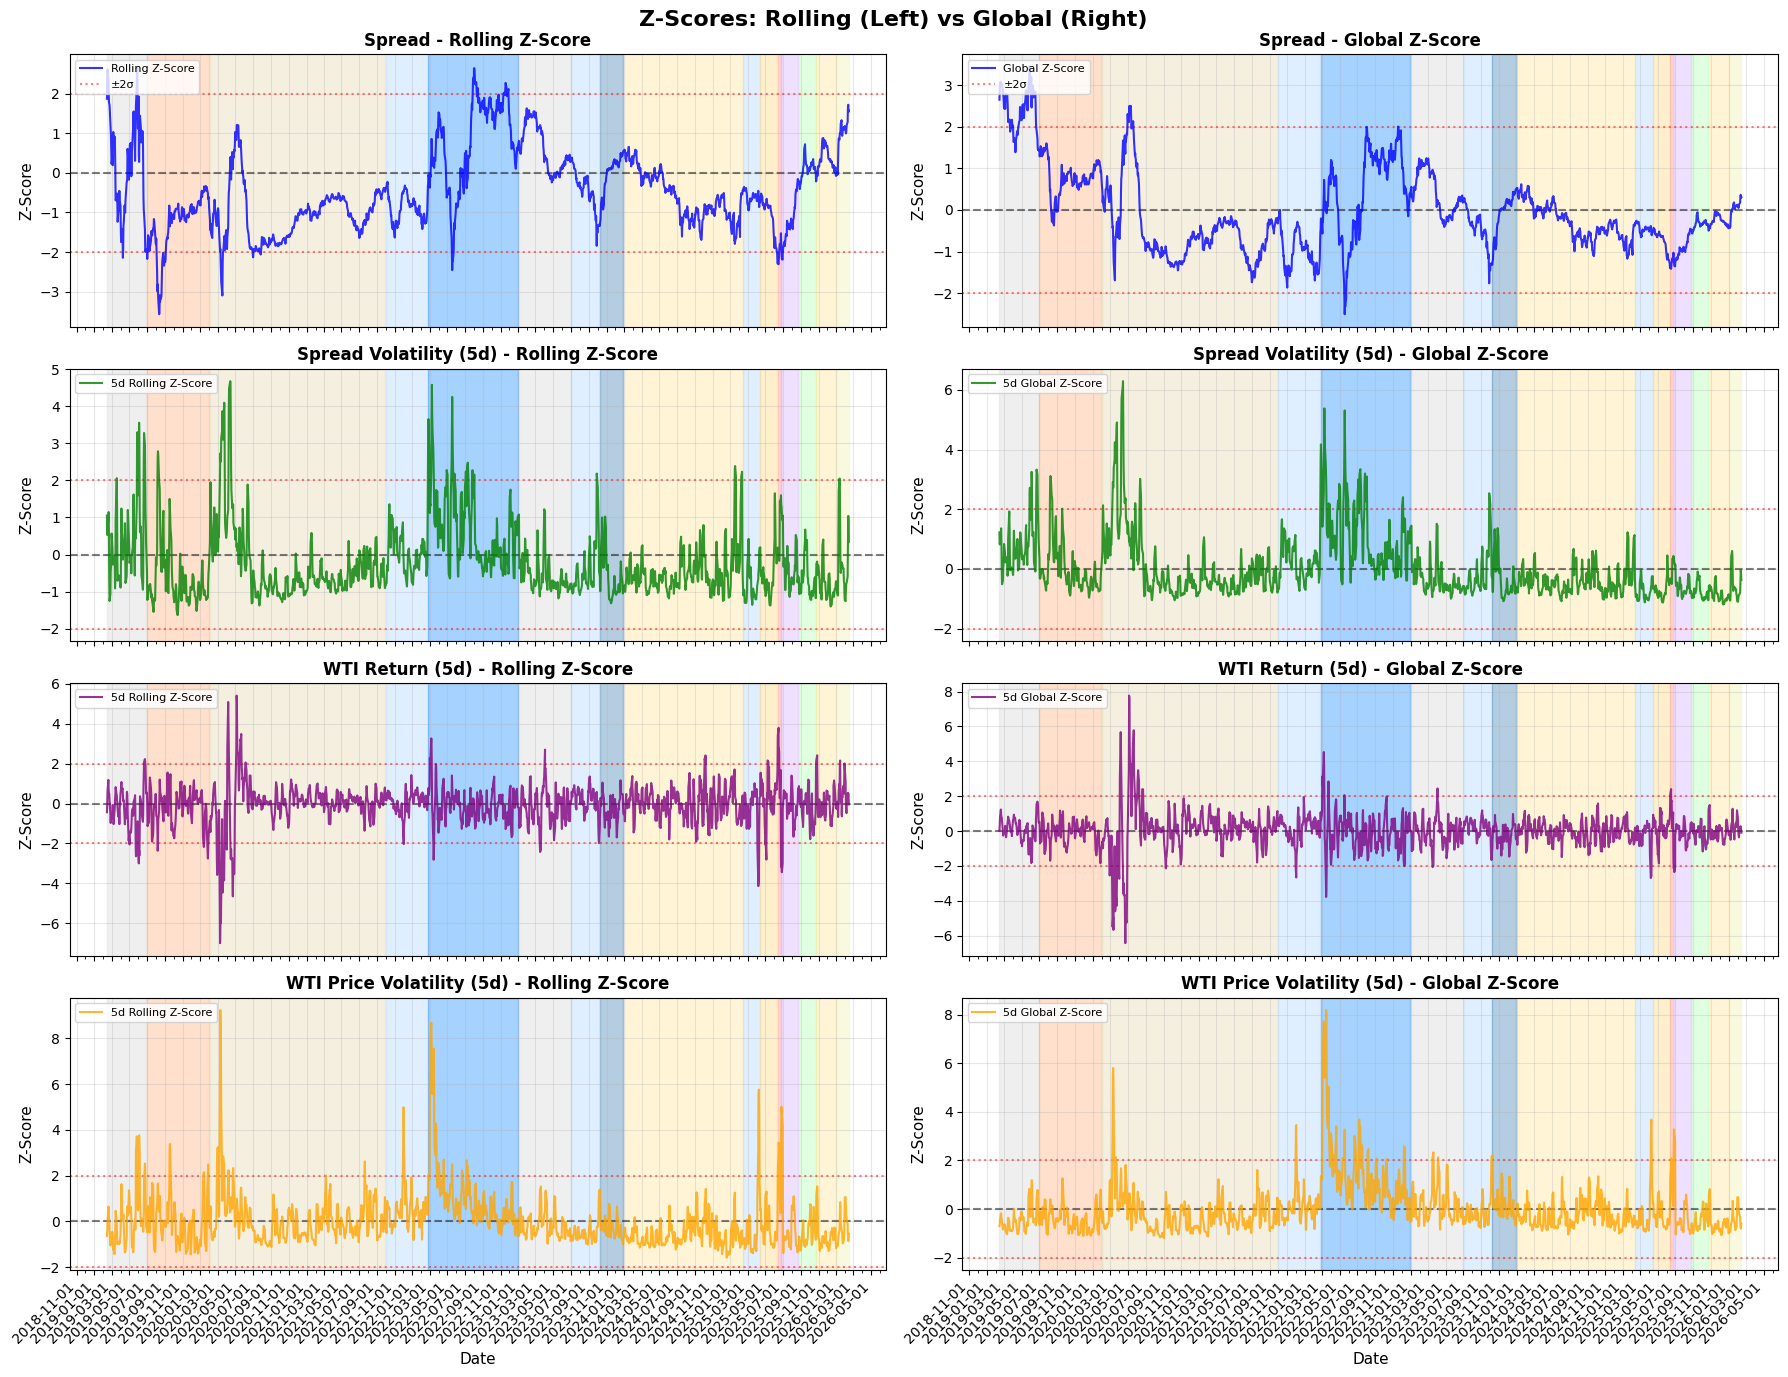


Z-SCORE VISUALIZATION COMPLETE

Note: Z-scores show how many standard deviations away from the mean
Values > |2| indicate extreme values (outside 95% confidence interval)


In [5]:
# ============================================================================
# VISUALIZE Z-SCORES
# ============================================================================

# Use the same background color function from previous cell
def add_label_background(ax, dates, labels, color_map):
    """Add background shading for different label periods"""
    current_label = None
    segment_start = None
    
    for i, (date, label) in enumerate(zip(dates, labels)):
        if label != current_label:
            if current_label is not None and segment_start is not None:
                ax.axvspan(segment_start, dates.iloc[i-1] if i > 0 else dates.iloc[0], 
                          alpha=0.4, color=color_map.get(current_label, 'white'), zorder=0)
            current_label = label
            segment_start = date
    
    if current_label is not None and segment_start is not None:
        ax.axvspan(segment_start, dates.iloc[-1], 
                  alpha=0.4, color=color_map.get(current_label, 'white'), zorder=0)

# Background colors for labels (more visible, saturated colors)
label_bg_colors = {
    # Training periods
    'Normal': (0.85, 0.85, 0.85),       # Medium gray - baseline periods
    'Normal-COVID': (0.9, 0.85, 0.7),   # Light brown/yellow for COVID impact (2020-2021, 2 years)
    'Normal-Tense': (1.0, 0.9, 0.6),     # Light orange/yellow for high-tension normal
    '2019-Tension': (1.0, 0.7, 0.5),     # Orange/red for 2019-Iran tension (Jul 2019 - Jan 2020)
    
    # Pre-War periods (consistent across all conflicts - light blue)
    'Pre-War Early': (0.7, 0.85, 1.0),   # Light blue
    'Pre-War Close': (1.0, 0.85, 0.5),   # Orange
    'Russia-Ukraine-Pre-War': (0.7, 0.85, 1.0),  # Same as Pre-War Early (light blue)
    'Israel-Hamas-Pre-War': (0.7, 0.85, 1.0),    # Same as Pre-War Early (light blue)
    
    # War periods (consistent across all conflicts - red)
    'War': (1.0, 0.6, 0.6),              # Red (Iran-related)
    'Russia-Ukraine-War': (0.12, 0.56, 1.0),       # Dodgerblue RGB - distinct from Iran War (red)
    'Israel-Hamas-War': (0.27, 0.51, 0.71),        # Steelblue RGB - distinct from Russia-Ukraine-War
    
    # Post-War periods (Iran-related only)
    'Post-War Close': (0.85, 0.7, 1.0),  # Purple
    'Post-War Late': (0.7, 1.0, 0.7),    # Green
    
    # Unlabeled
    'Unlabeled': (0.95, 0.95, 0.7)       # Light yellow for unlabeled data
}

# Create visualization for z-scores
fig, axes = plt.subplots(4, 2, figsize=(18, 14), sharex=True)
fig.suptitle('Z-Scores: Rolling (Left) vs Global (Right)', fontsize=16, fontweight='bold')

# Plot spread z-scores
add_label_background(axes[0, 0], df_final['date'], df_final['label'], label_bg_colors)
axes[0, 0].plot(df_final['date'], df_final['spread_zscore_rolling'], linewidth=1.5, alpha=0.8, color='blue', label='Rolling Z-Score', zorder=3)
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 0].axhline(y=2, color='red', linestyle=':', alpha=0.5, label='±2σ')
axes[0, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[0, 0].set_ylabel('Z-Score', fontsize=11)
axes[0, 0].set_title('Spread - Rolling Z-Score', fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='upper left', fontsize=8)
axes[0, 0].grid(True, alpha=0.3)

add_label_background(axes[0, 1], df_final['date'], df_final['label'], label_bg_colors)
axes[0, 1].plot(df_final['date'], df_final['spread_zscore_global'], linewidth=1.5, alpha=0.8, color='blue', label='Global Z-Score', zorder=3)
axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].axhline(y=2, color='red', linestyle=':', alpha=0.5, label='±2σ')
axes[0, 1].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[0, 1].set_ylabel('Z-Score', fontsize=11)
axes[0, 1].set_title('Spread - Global Z-Score', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='upper left', fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# Plot spread volatility z-scores (5d as example)
add_label_background(axes[1, 0], df_final['date'], df_final['label'], label_bg_colors)
axes[1, 0].plot(df_final['date'], df_final['spread_vol_5d_zscore_rolling'], linewidth=1.5, alpha=0.8, color='green', label='5d Rolling Z-Score', zorder=3)
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].axhline(y=2, color='red', linestyle=':', alpha=0.5)
axes[1, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[1, 0].set_ylabel('Z-Score', fontsize=11)
axes[1, 0].set_title('Spread Volatility (5d) - Rolling Z-Score', fontsize=12, fontweight='bold')
axes[1, 0].legend(loc='upper left', fontsize=8)
axes[1, 0].grid(True, alpha=0.3)

add_label_background(axes[1, 1], df_final['date'], df_final['label'], label_bg_colors)
axes[1, 1].plot(df_final['date'], df_final['spread_vol_5d_zscore_global'], linewidth=1.5, alpha=0.8, color='green', label='5d Global Z-Score', zorder=3)
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].axhline(y=2, color='red', linestyle=':', alpha=0.5)
axes[1, 1].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[1, 1].set_ylabel('Z-Score', fontsize=11)
axes[1, 1].set_title('Spread Volatility (5d) - Global Z-Score', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='upper left', fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

# Plot WTI return z-scores (5d as example)
add_label_background(axes[2, 0], df_final['date'], df_final['label'], label_bg_colors)
axes[2, 0].plot(df_final['date'], df_final['WTI_return_5d_zscore_rolling'], linewidth=1.5, alpha=0.8, color='purple', label='5d Rolling Z-Score', zorder=3)
axes[2, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[2, 0].axhline(y=2, color='red', linestyle=':', alpha=0.5)
axes[2, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[2, 0].set_ylabel('Z-Score', fontsize=11)
axes[2, 0].set_title('WTI Return (5d) - Rolling Z-Score', fontsize=12, fontweight='bold')
axes[2, 0].legend(loc='upper left', fontsize=8)
axes[2, 0].grid(True, alpha=0.3)

add_label_background(axes[2, 1], df_final['date'], df_final['label'], label_bg_colors)
axes[2, 1].plot(df_final['date'], df_final['WTI_return_5d_zscore_global'], linewidth=1.5, alpha=0.8, color='purple', label='5d Global Z-Score', zorder=3)
axes[2, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[2, 1].axhline(y=2, color='red', linestyle=':', alpha=0.5)
axes[2, 1].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[2, 1].set_ylabel('Z-Score', fontsize=11)
axes[2, 1].set_title('WTI Return (5d) - Global Z-Score', fontsize=12, fontweight='bold')
axes[2, 1].legend(loc='upper left', fontsize=8)
axes[2, 1].grid(True, alpha=0.3)

# Plot WTI price volatility z-scores (5d as example)
add_label_background(axes[3, 0], df_final['date'], df_final['label'], label_bg_colors)
axes[3, 0].plot(df_final['date'], df_final['WTI_price_vol_5d_zscore_rolling'], linewidth=1.5, alpha=0.8, color='orange', label='5d Rolling Z-Score', zorder=3)
axes[3, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[3, 0].axhline(y=2, color='red', linestyle=':', alpha=0.5)
axes[3, 0].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[3, 0].set_ylabel('Z-Score', fontsize=11)
axes[3, 0].set_xlabel('Date', fontsize=11)
axes[3, 0].set_title('WTI Price Volatility (5d) - Rolling Z-Score', fontsize=12, fontweight='bold')
axes[3, 0].legend(loc='upper left', fontsize=8)
axes[3, 0].grid(True, alpha=0.3)

add_label_background(axes[3, 1], df_final['date'], df_final['label'], label_bg_colors)
axes[3, 1].plot(df_final['date'], df_final['WTI_price_vol_5d_zscore_global'], linewidth=1.5, alpha=0.8, color='orange', label='5d Global Z-Score', zorder=3)
axes[3, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[3, 1].axhline(y=2, color='red', linestyle=':', alpha=0.5)
axes[3, 1].axhline(y=-2, color='red', linestyle=':', alpha=0.5)
axes[3, 1].set_ylabel('Z-Score', fontsize=11)
axes[3, 1].set_xlabel('Date', fontsize=11)
axes[3, 1].set_title('WTI Price Volatility (5d) - Global Z-Score', fontsize=12, fontweight='bold')
axes[3, 1].legend(loc='upper left', fontsize=8)
axes[3, 1].grid(True, alpha=0.3)

# Format x-axis dates
from matplotlib.dates import DateFormatter, MonthLocator
date_format = DateFormatter('%Y-%m-%d')
month_locator = MonthLocator(interval=2)

for ax in axes.flat:
    ax.xaxis.set_major_locator(month_locator)
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_minor_locator(MonthLocator())
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()

# Save figure to images folder
images_dir = Path('images')
images_dir.mkdir(exist_ok=True)
fig.savefig(images_dir / 'data2.png', dpi=150, bbox_inches='tight')
print(f"\n💾 Saved visualization to {images_dir / 'data2.png'}")

plt.show()

print(f"\n{'='*80}")
print("Z-SCORE VISUALIZATION COMPLETE")
print(f"{'='*80}")
print("\nNote: Z-scores show how many standard deviations away from the mean")
print("Values > |2| indicate extreme values (outside 95% confidence interval)")

In [6]:

# Define colors for each label
label_colors = {
    'Normal': 'gray',
    'Normal-COVID': 'tan',               # Brown/tan for Normal-COVID (2020-2021)
    'Normal-Tense': 'yellow',            # Bright yellow - distinct from Pre-War Close (orange)
    '2019-Tension': 'olive',        # Dark orange for 2019-Iran tension (Jul 2019 - Jan 2020)
    'Pre-War Early': 'green',
    'Pre-War Close': 'orange',           # Orange - distinct from Normal-Tense (yellow)
    'Russia-Ukraine-Pre-War': 'steelblue',  # Same as Pre-War Early
    'Israel-Hamas-Pre-War': 'cyan',     # Same as Pre-War Early
    'War': 'red',                        # Red for Iran-related war
    'Russia-Ukraine-War': 'dodgerblue',     # Blue - distinct from Iran War (red)
    'Israel-Hamas-War': 'navy',        # Darker blue - distinct from Russia-Ukraine-War
    'Post-War Close': 'purple',
    'Post-War Late': 'lightgray',
    'Unlabeled': 'black'
}

# 2026 data segment colors for scatter plots (x = 2026): last 5 days = red, next 10 days = dark blue, rest = black
UNLABELED_2026_COLORS = {'last_5': 'red', 'next_10': 'darkblue', 'rest': 'black'}
UNLABELED_2026_LABELS = {'last_5': '2026 (last 5d)', 'next_10': '2026 (6–15d)', 'rest': '2026 (rest)'}

def add_2026_segment_colors(df_u):
    """Add _2026_segment and _2026_color columns for 3-way coloring: last 5 days (red), next 10 days (dark blue), rest (black)."""
    if len(df_u) == 0:
        return df_u
    df_u = df_u.sort_values('date').copy()
    max_date = df_u['date'].max()
    df_u['_2026_segment'] = 'rest'
    df_u.loc[(df_u['date'] >= max_date - pd.Timedelta(days=14)) & (df_u['date'] < max_date - pd.Timedelta(days=4)), '_2026_segment'] = 'next_10'
    df_u.loc[df_u['date'] >= max_date - pd.Timedelta(days=4), '_2026_segment'] = 'last_5'
    df_u['_2026_color'] = df_u['_2026_segment'].map(UNLABELED_2026_COLORS)
    return df_u

Labeled data (after filtering): 1753 points
Unlabeled data (2026+): 37 points
Note: Russia-Ukraine-War filtered to first 2 months only (Feb 24 - Apr 24, 2022)

💾 Saved visualization to images/data3.png


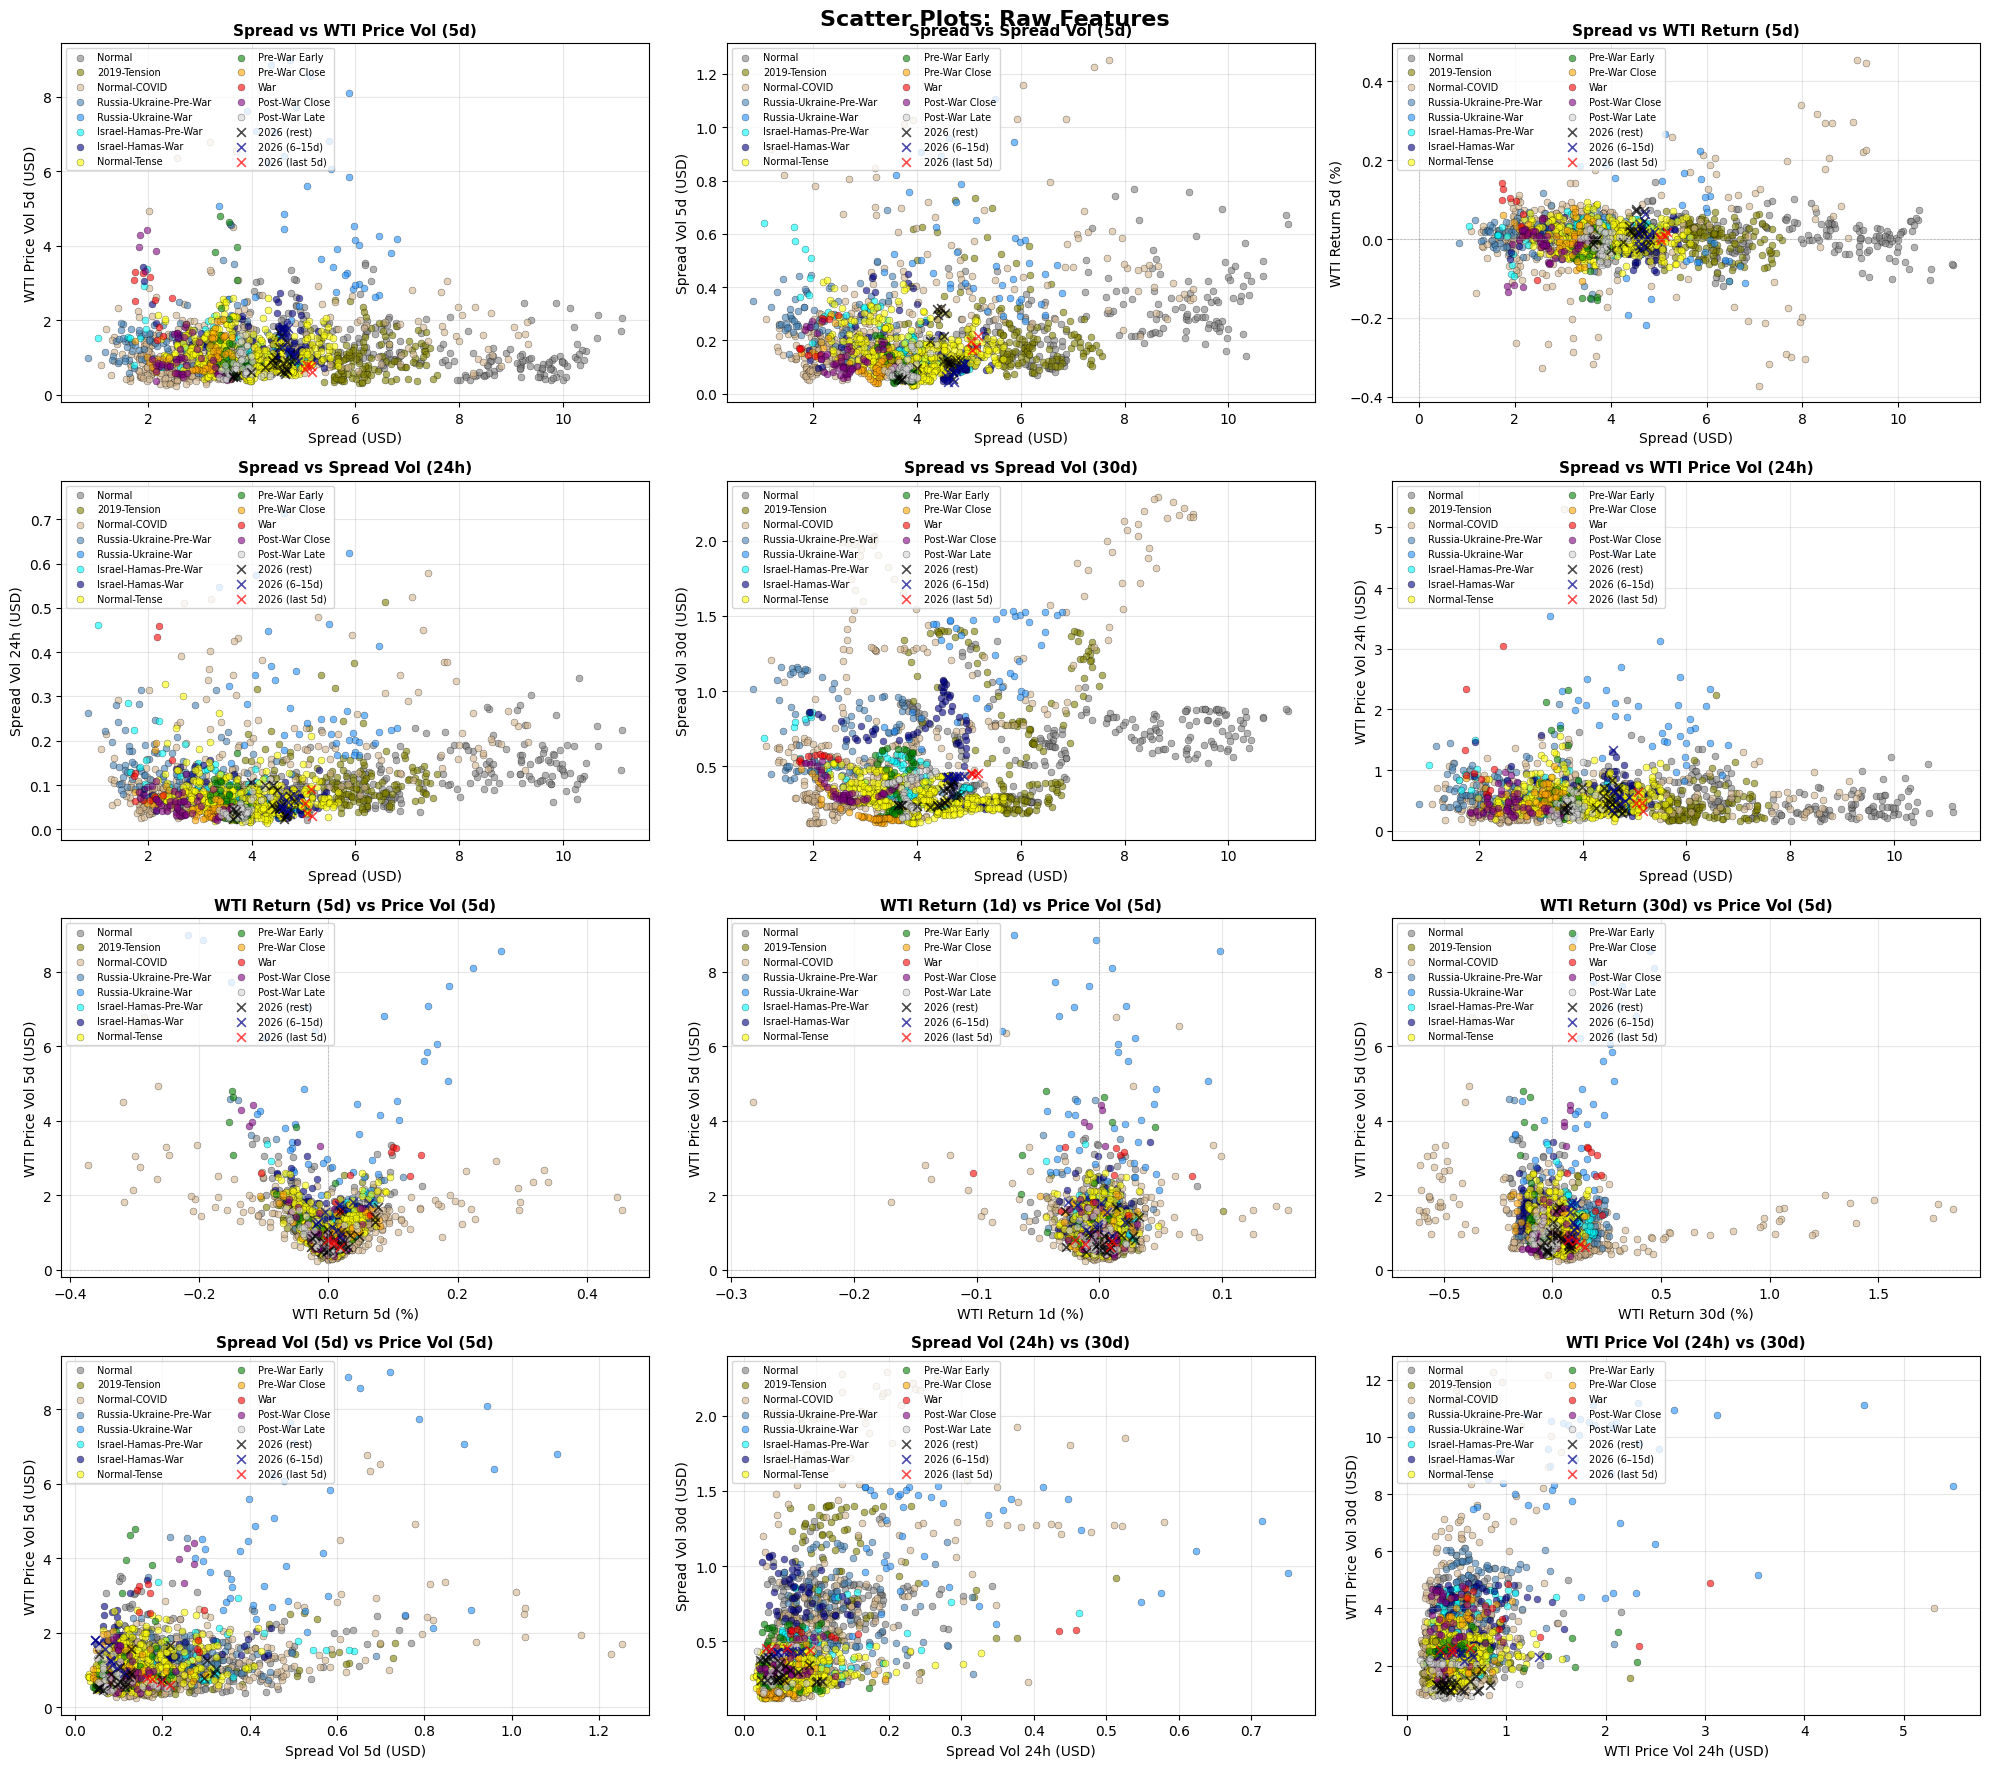


RAW FEATURE SCATTER PLOTS COMPLETE


In [7]:
# ============================================================================
# SCATTER PLOTS: RAW FEATURES
# ============================================================================


# Split data into labeled (2024-2025) and unlabeled (2026+)
cutoff_date = pd.Timestamp('2026-01-01', tz='UTC')
df_labeled = df_final[df_final['date'] < cutoff_date].copy()
df_unlabeled = df_final[df_final['date'] >= cutoff_date].copy()
df_unlabeled = add_2026_segment_colors(df_unlabeled)

# Filter Russia-Ukraine-War to only show first 2 months (Feb 24 - Apr 24, 2022)
# This makes scatter plots cleaner by excluding later months that may be returning to normal
ru_war_start = pd.Timestamp('2022-02-24', tz='UTC')
ru_war_2month_end = pd.Timestamp('2022-04-24', tz='UTC')
mask_ru_war_later = (df_labeled['label'] == 'Russia-Ukraine-War') & \
                    (df_labeled['date'] > ru_war_2month_end)
df_labeled = df_labeled[~mask_ru_war_later].copy()

print(f"Labeled data (after filtering): {len(df_labeled)} points")
print(f"Unlabeled data (2026+): {len(df_unlabeled)} points")
print(f"Note: Russia-Ukraine-War filtered to first 2 months only (Feb 24 - Apr 24, 2022)")
print(f"{'='*80}")

# Create scatter plots for feature pairs - expanded grid
fig, axes = plt.subplots(4, 3, figsize=(20, 18))
fig.suptitle('Scatter Plots: Raw Features', fontsize=16, fontweight='bold')

# Helper function to create scatter plot
def create_scatter(ax, x_data, y_data, x_label, y_label, title, show_zero_line=False):
    for label in df_labeled['label'].unique():
        mask = df_labeled['label'] == label
        ax.scatter(df_labeled.loc[mask, x_data], 
                  df_labeled.loc[mask, y_data],
                  c=label_colors.get(label, 'black'), 
                  label=label, alpha=0.6, s=25, edgecolors='black', linewidth=0.3)
    if len(df_unlabeled) > 0:
        for seg in ['rest', 'next_10', 'last_5']:
            mask = df_unlabeled['_2026_segment'] == seg
            if mask.any():
                ax.scatter(df_unlabeled.loc[mask, x_data], df_unlabeled.loc[mask, y_data],
                          c=UNLABELED_2026_COLORS[seg], marker='x', s=40, label=UNLABELED_2026_LABELS[seg], alpha=0.7, linewidth=1.2)
    ax.set_xlabel(x_label, fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    if show_zero_line:
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.legend(loc='upper left', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)

# Row 1: Spread vs various features
create_scatter(axes[0, 0], 'spread', 'WTI_price_vol_5d', 'Spread (USD)', 'WTI Price Vol 5d (USD)', 'Spread vs WTI Price Vol (5d)')
create_scatter(axes[0, 1], 'spread', 'spread_vol_5d', 'Spread (USD)', 'Spread Vol 5d (USD)', 'Spread vs Spread Vol (5d)')
create_scatter(axes[0, 2], 'spread', 'WTI_return_5d', 'Spread (USD)', 'WTI Return 5d (%)', 'Spread vs WTI Return (5d)', show_zero_line=True)

# Row 2: Spread vs different timeframes
create_scatter(axes[1, 0], 'spread', 'spread_vol_24h', 'Spread (USD)', 'Spread Vol 24h (USD)', 'Spread vs Spread Vol (24h)')
create_scatter(axes[1, 1], 'spread', 'spread_vol_30d', 'Spread (USD)', 'Spread Vol 30d (USD)', 'Spread vs Spread Vol (30d)')
create_scatter(axes[1, 2], 'spread', 'WTI_price_vol_24h', 'Spread (USD)', 'WTI Price Vol 24h (USD)', 'Spread vs WTI Price Vol (24h)')

# Row 3: Returns vs Volatilities
create_scatter(axes[2, 0], 'WTI_return_5d', 'WTI_price_vol_5d', 'WTI Return 5d (%)', 'WTI Price Vol 5d (USD)', 'WTI Return (5d) vs Price Vol (5d)', show_zero_line=True)
create_scatter(axes[2, 1], 'WTI_return_1d', 'WTI_price_vol_5d', 'WTI Return 1d (%)', 'WTI Price Vol 5d (USD)', 'WTI Return (1d) vs Price Vol (5d)', show_zero_line=True)
create_scatter(axes[2, 2], 'WTI_return_30d', 'WTI_price_vol_5d', 'WTI Return 30d (%)', 'WTI Price Vol 5d (USD)', 'WTI Return (30d) vs Price Vol (5d)', show_zero_line=True)

# Row 4: Volatility comparisons
create_scatter(axes[3, 0], 'spread_vol_5d', 'WTI_price_vol_5d', 'Spread Vol 5d (USD)', 'WTI Price Vol 5d (USD)', 'Spread Vol (5d) vs Price Vol (5d)')
create_scatter(axes[3, 1], 'spread_vol_24h', 'spread_vol_30d', 'Spread Vol 24h (USD)', 'Spread Vol 30d (USD)', 'Spread Vol (24h) vs (30d)')
create_scatter(axes[3, 2], 'WTI_price_vol_24h', 'WTI_price_vol_30d', 'WTI Price Vol 24h (USD)', 'WTI Price Vol 30d (USD)', 'WTI Price Vol (24h) vs (30d)')

plt.tight_layout()

# Save figure to images folder
images_dir = Path('images')
images_dir.mkdir(exist_ok=True)
fig.savefig(images_dir / 'data3.png', dpi=150, bbox_inches='tight')
print(f"\n💾 Saved visualization to {images_dir / 'data3.png'}")

plt.show()

print(f"\n{'='*80}")
print("RAW FEATURE SCATTER PLOTS COMPLETE")
print(f"{'='*80}")

Labeled data (after filtering): 1753 points
Unlabeled data (2026+): 37 points
Note: Russia-Ukraine-War filtered to first 2 months only (Feb 24 - Apr 24, 2022)

💾 Saved visualization to images/data4.png


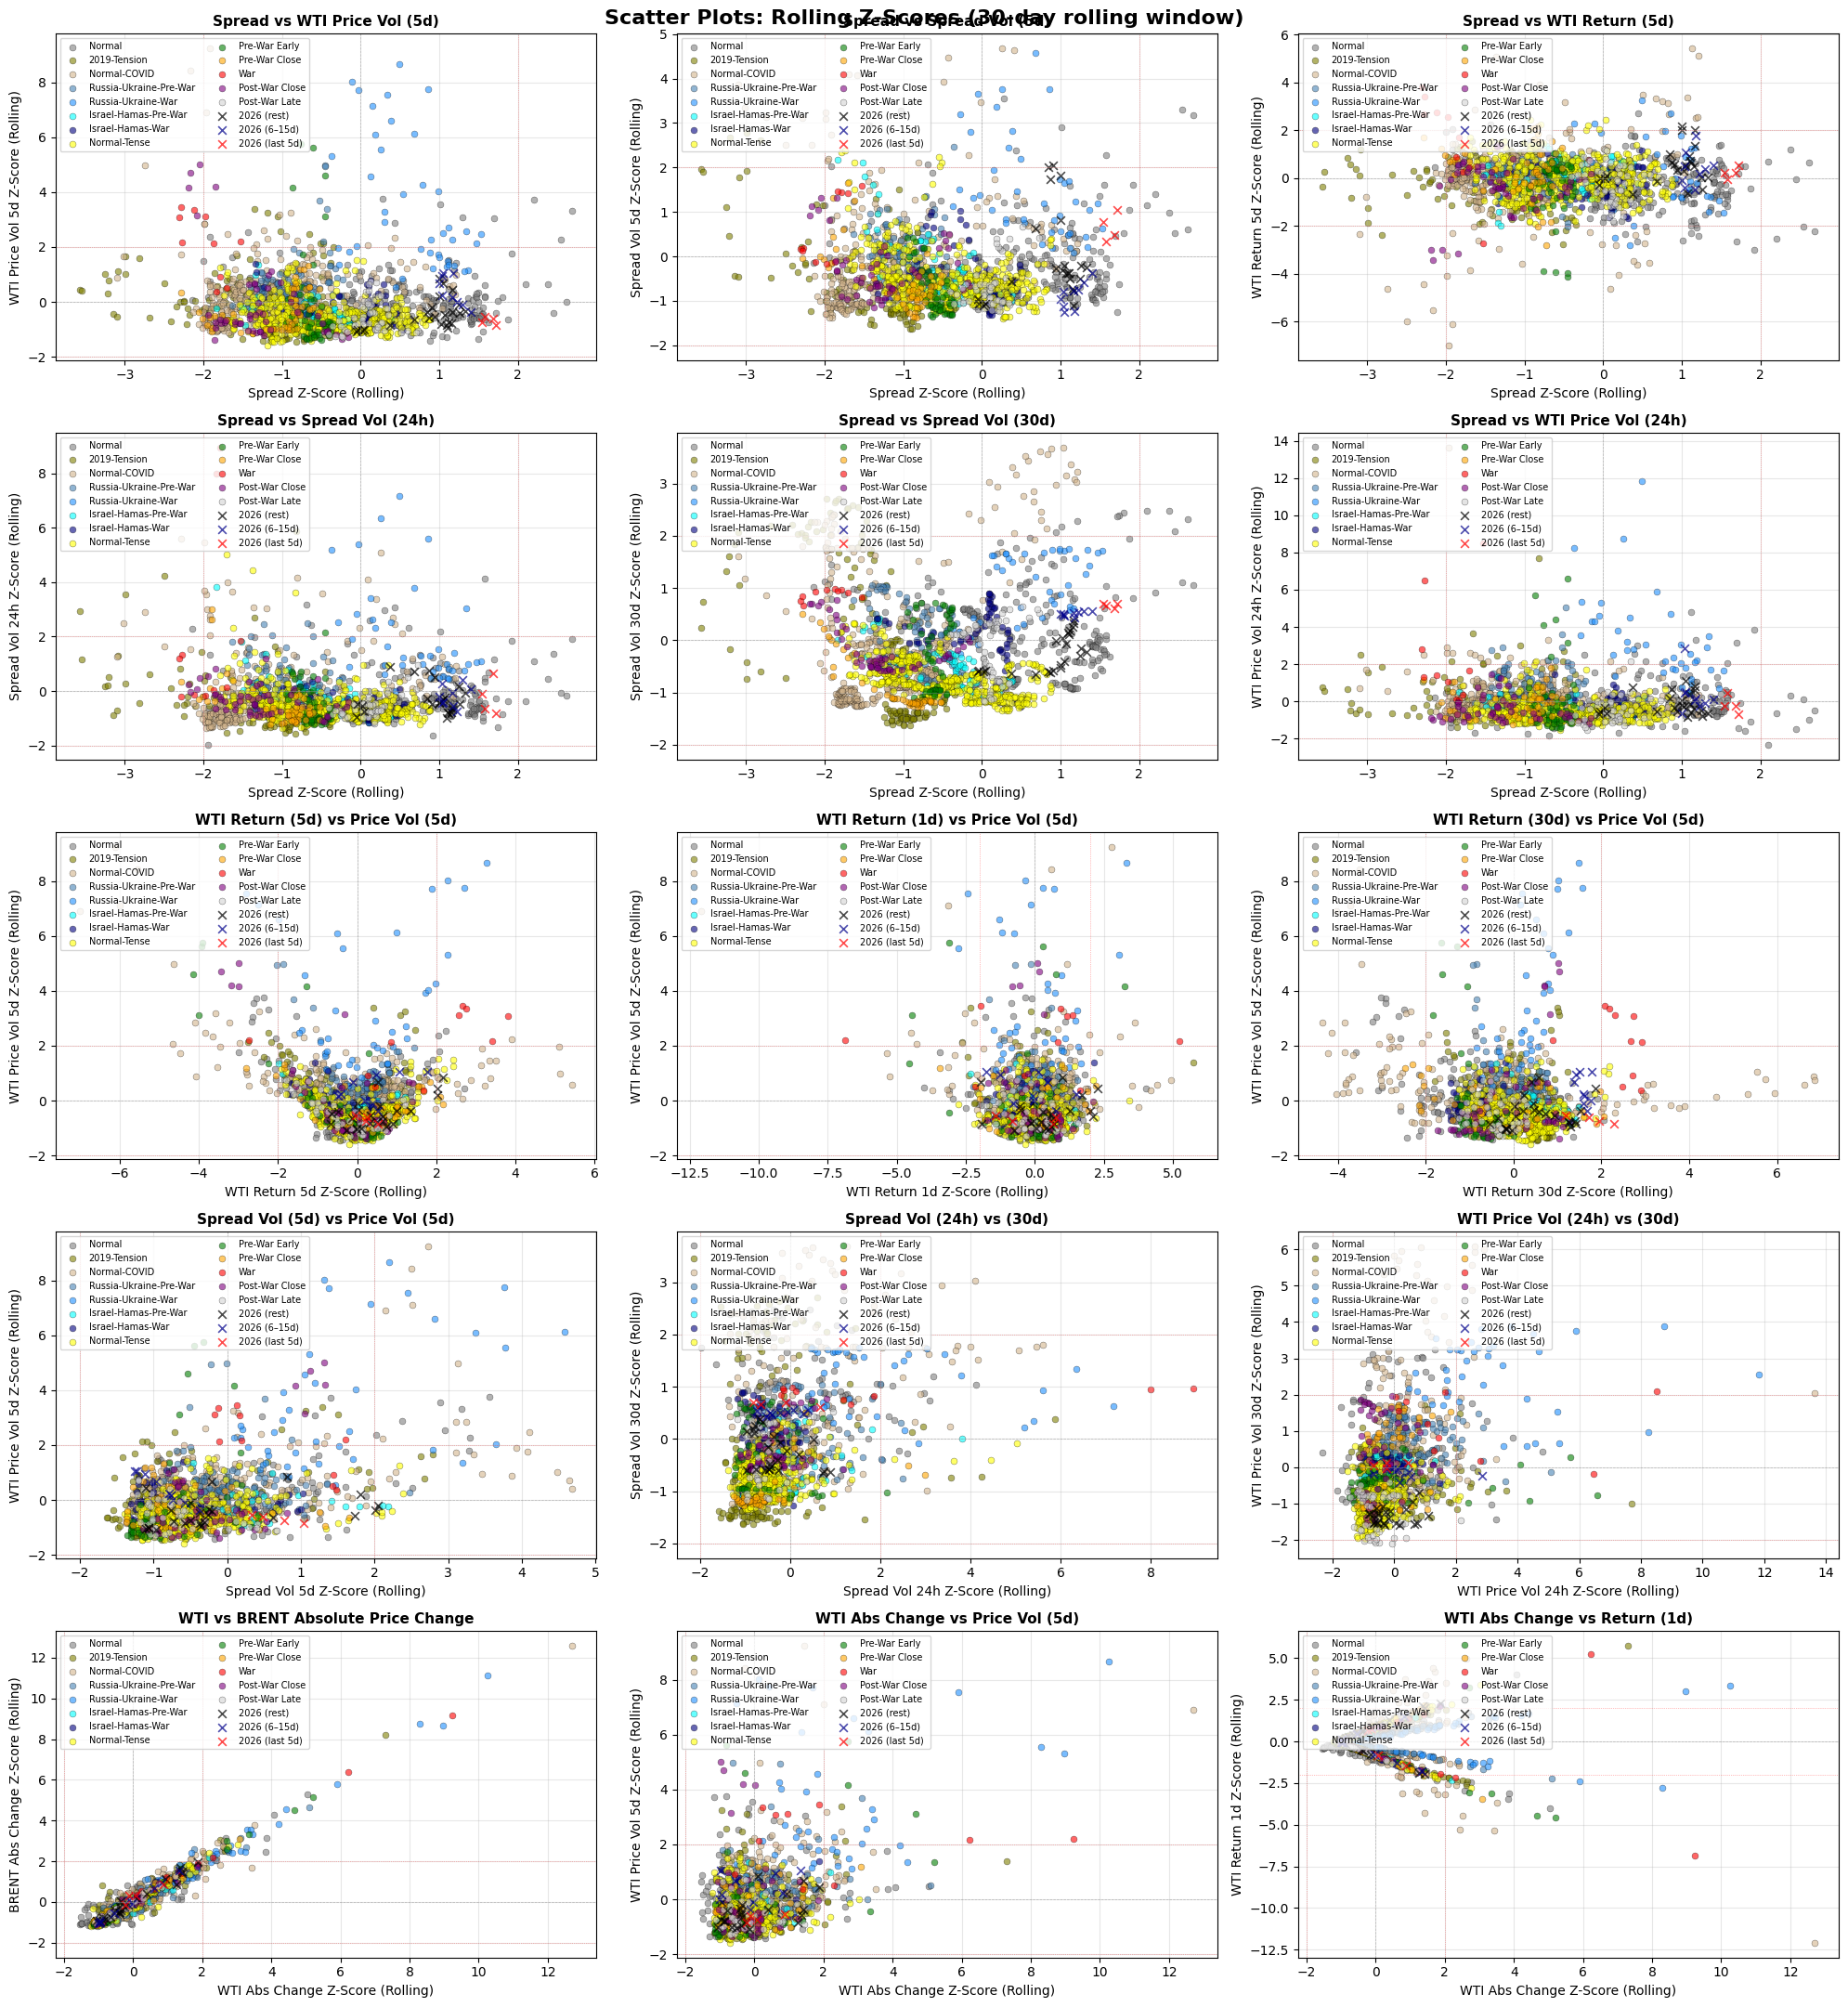


ROLLING Z-SCORE SCATTER PLOTS COMPLETE
Note: ±2σ lines indicate extreme values (outside 95% confidence interval)


In [8]:
# ============================================================================
# SCATTER PLOTS: ROLLING Z-SCORES
# ============================================================================


# Split data into labeled (2024-2025) and unlabeled (2026+)
cutoff_date = pd.Timestamp('2026-01-01', tz='UTC')
df_labeled = df_final[df_final['date'] < cutoff_date].copy()
df_unlabeled = df_final[df_final['date'] >= cutoff_date].copy()
df_unlabeled = add_2026_segment_colors(df_unlabeled)

# Filter Russia-Ukraine-War to only show first 2 months (Feb 24 - Apr 24, 2022)
# This makes scatter plots cleaner by excluding later months that may be returning to normal
ru_war_start = pd.Timestamp('2022-02-24', tz='UTC')
ru_war_2month_end = pd.Timestamp('2022-04-24', tz='UTC')
mask_ru_war_later = (df_labeled['label'] == 'Russia-Ukraine-War') & \
                    (df_labeled['date'] > ru_war_2month_end)
df_labeled = df_labeled[~mask_ru_war_later].copy()

print(f"Labeled data (after filtering): {len(df_labeled)} points")
print(f"Unlabeled data (2026+): {len(df_unlabeled)} points")
print(f"Note: Russia-Ukraine-War filtered to first 2 months only (Feb 24 - Apr 24, 2022)")
print(f"{'='*80}")

# Create scatter plots for rolling z-score pairs - expanded grid
fig, axes = plt.subplots(5, 3, figsize=(20, 22))
fig.suptitle('Scatter Plots: Rolling Z-Scores (30-day rolling window)', fontsize=16, fontweight='bold')

# Helper function to create scatter plot with z-score reference lines
def create_zscore_scatter(ax, x_data, y_data, x_label, y_label, title):
    for label in df_labeled['label'].unique():
        mask = df_labeled['label'] == label
        ax.scatter(df_labeled.loc[mask, x_data], 
                  df_labeled.loc[mask, y_data],
                  c=label_colors.get(label, 'black'), 
                  label=label, alpha=0.6, s=25, edgecolors='black', linewidth=0.3)
    if len(df_unlabeled) > 0:
        for seg in ['rest', 'next_10', 'last_5']:
            mask = df_unlabeled['_2026_segment'] == seg
            if mask.any():
                ax.scatter(df_unlabeled.loc[mask, x_data], df_unlabeled.loc[mask, y_data],
                          c=UNLABELED_2026_COLORS[seg], marker='x', s=40, label=UNLABELED_2026_LABELS[seg], alpha=0.7, linewidth=1.2)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.axhline(y=2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.axhline(y=-2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.axvline(x=2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.axvline(x=-2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.set_xlabel(x_label, fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.legend(loc='upper left', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)

# Row 1: Spread z-scores vs various features
create_zscore_scatter(axes[0, 0], 'spread_zscore_rolling', 'WTI_price_vol_5d_zscore_rolling', 
                     'Spread Z-Score (Rolling)', 'WTI Price Vol 5d Z-Score (Rolling)', 'Spread vs WTI Price Vol (5d)')
create_zscore_scatter(axes[0, 1], 'spread_zscore_rolling', 'spread_vol_5d_zscore_rolling', 
                     'Spread Z-Score (Rolling)', 'Spread Vol 5d Z-Score (Rolling)', 'Spread vs Spread Vol (5d)')
create_zscore_scatter(axes[0, 2], 'spread_zscore_rolling', 'WTI_return_5d_zscore_rolling', 
                     'Spread Z-Score (Rolling)', 'WTI Return 5d Z-Score (Rolling)', 'Spread vs WTI Return (5d)')

# Row 2: Spread z-scores vs different timeframes
create_zscore_scatter(axes[1, 0], 'spread_zscore_rolling', 'spread_vol_24h_zscore_rolling', 
                     'Spread Z-Score (Rolling)', 'Spread Vol 24h Z-Score (Rolling)', 'Spread vs Spread Vol (24h)')
create_zscore_scatter(axes[1, 1], 'spread_zscore_rolling', 'spread_vol_30d_zscore_rolling', 
                     'Spread Z-Score (Rolling)', 'Spread Vol 30d Z-Score (Rolling)', 'Spread vs Spread Vol (30d)')
create_zscore_scatter(axes[1, 2], 'spread_zscore_rolling', 'WTI_price_vol_24h_zscore_rolling', 
                     'Spread Z-Score (Rolling)', 'WTI Price Vol 24h Z-Score (Rolling)', 'Spread vs WTI Price Vol (24h)')

# Row 3: Returns z-scores vs Volatilities z-scores
create_zscore_scatter(axes[2, 0], 'WTI_return_5d_zscore_rolling', 'WTI_price_vol_5d_zscore_rolling', 
                     'WTI Return 5d Z-Score (Rolling)', 'WTI Price Vol 5d Z-Score (Rolling)', 'WTI Return (5d) vs Price Vol (5d)')
create_zscore_scatter(axes[2, 1], 'WTI_return_1d_zscore_rolling', 'WTI_price_vol_5d_zscore_rolling', 
                     'WTI Return 1d Z-Score (Rolling)', 'WTI Price Vol 5d Z-Score (Rolling)', 'WTI Return (1d) vs Price Vol (5d)')
create_zscore_scatter(axes[2, 2], 'WTI_return_30d_zscore_rolling', 'WTI_price_vol_5d_zscore_rolling', 
                     'WTI Return 30d Z-Score (Rolling)', 'WTI Price Vol 5d Z-Score (Rolling)', 'WTI Return (30d) vs Price Vol (5d)')

# Row 4: Volatility z-score comparisons
create_zscore_scatter(axes[3, 0], 'spread_vol_5d_zscore_rolling', 'WTI_price_vol_5d_zscore_rolling', 
                     'Spread Vol 5d Z-Score (Rolling)', 'WTI Price Vol 5d Z-Score (Rolling)', 'Spread Vol (5d) vs Price Vol (5d)')
create_zscore_scatter(axes[3, 1], 'spread_vol_24h_zscore_rolling', 'spread_vol_30d_zscore_rolling', 
                     'Spread Vol 24h Z-Score (Rolling)', 'Spread Vol 30d Z-Score (Rolling)', 'Spread Vol (24h) vs (30d)')
create_zscore_scatter(axes[3, 2], 'WTI_price_vol_24h_zscore_rolling', 'WTI_price_vol_30d_zscore_rolling', 
                     'WTI Price Vol 24h Z-Score (Rolling)', 'WTI Price Vol 30d Z-Score (Rolling)', 'WTI Price Vol (24h) vs (30d)')

# Row 5: Absolute price change z-score comparisons
create_zscore_scatter(axes[4, 0], 'WTI_abs_change_zscore_rolling', 'BRENT_abs_change_zscore_rolling', 
                     'WTI Abs Change Z-Score (Rolling)', 'BRENT Abs Change Z-Score (Rolling)', 'WTI vs BRENT Absolute Price Change')
create_zscore_scatter(axes[4, 1], 'WTI_abs_change_zscore_rolling', 'WTI_price_vol_5d_zscore_rolling', 
                     'WTI Abs Change Z-Score (Rolling)', 'WTI Price Vol 5d Z-Score (Rolling)', 'WTI Abs Change vs Price Vol (5d)')
create_zscore_scatter(axes[4, 2], 'WTI_abs_change_zscore_rolling', 'WTI_return_1d_zscore_rolling', 
                     'WTI Abs Change Z-Score (Rolling)', 'WTI Return 1d Z-Score (Rolling)', 'WTI Abs Change vs Return (1d)')

plt.tight_layout()

# Save figure to images folder
images_dir = Path('images')
images_dir.mkdir(exist_ok=True)
fig.savefig(images_dir / 'data4.png', dpi=150, bbox_inches='tight')
print(f"\n💾 Saved visualization to {images_dir / 'data4.png'}")

plt.show()

print(f"\n{'='*80}")
print("ROLLING Z-SCORE SCATTER PLOTS COMPLETE")
print(f"{'='*80}")
print("Note: ±2σ lines indicate extreme values (outside 95% confidence interval)")

Labeled data (after filtering): 1753 points
Unlabeled data (2026+): 37 points
Note: Russia-Ukraine-War filtered to first 2 months only (Feb 24 - Apr 24, 2022)

💾 Saved visualization to images/data5.png


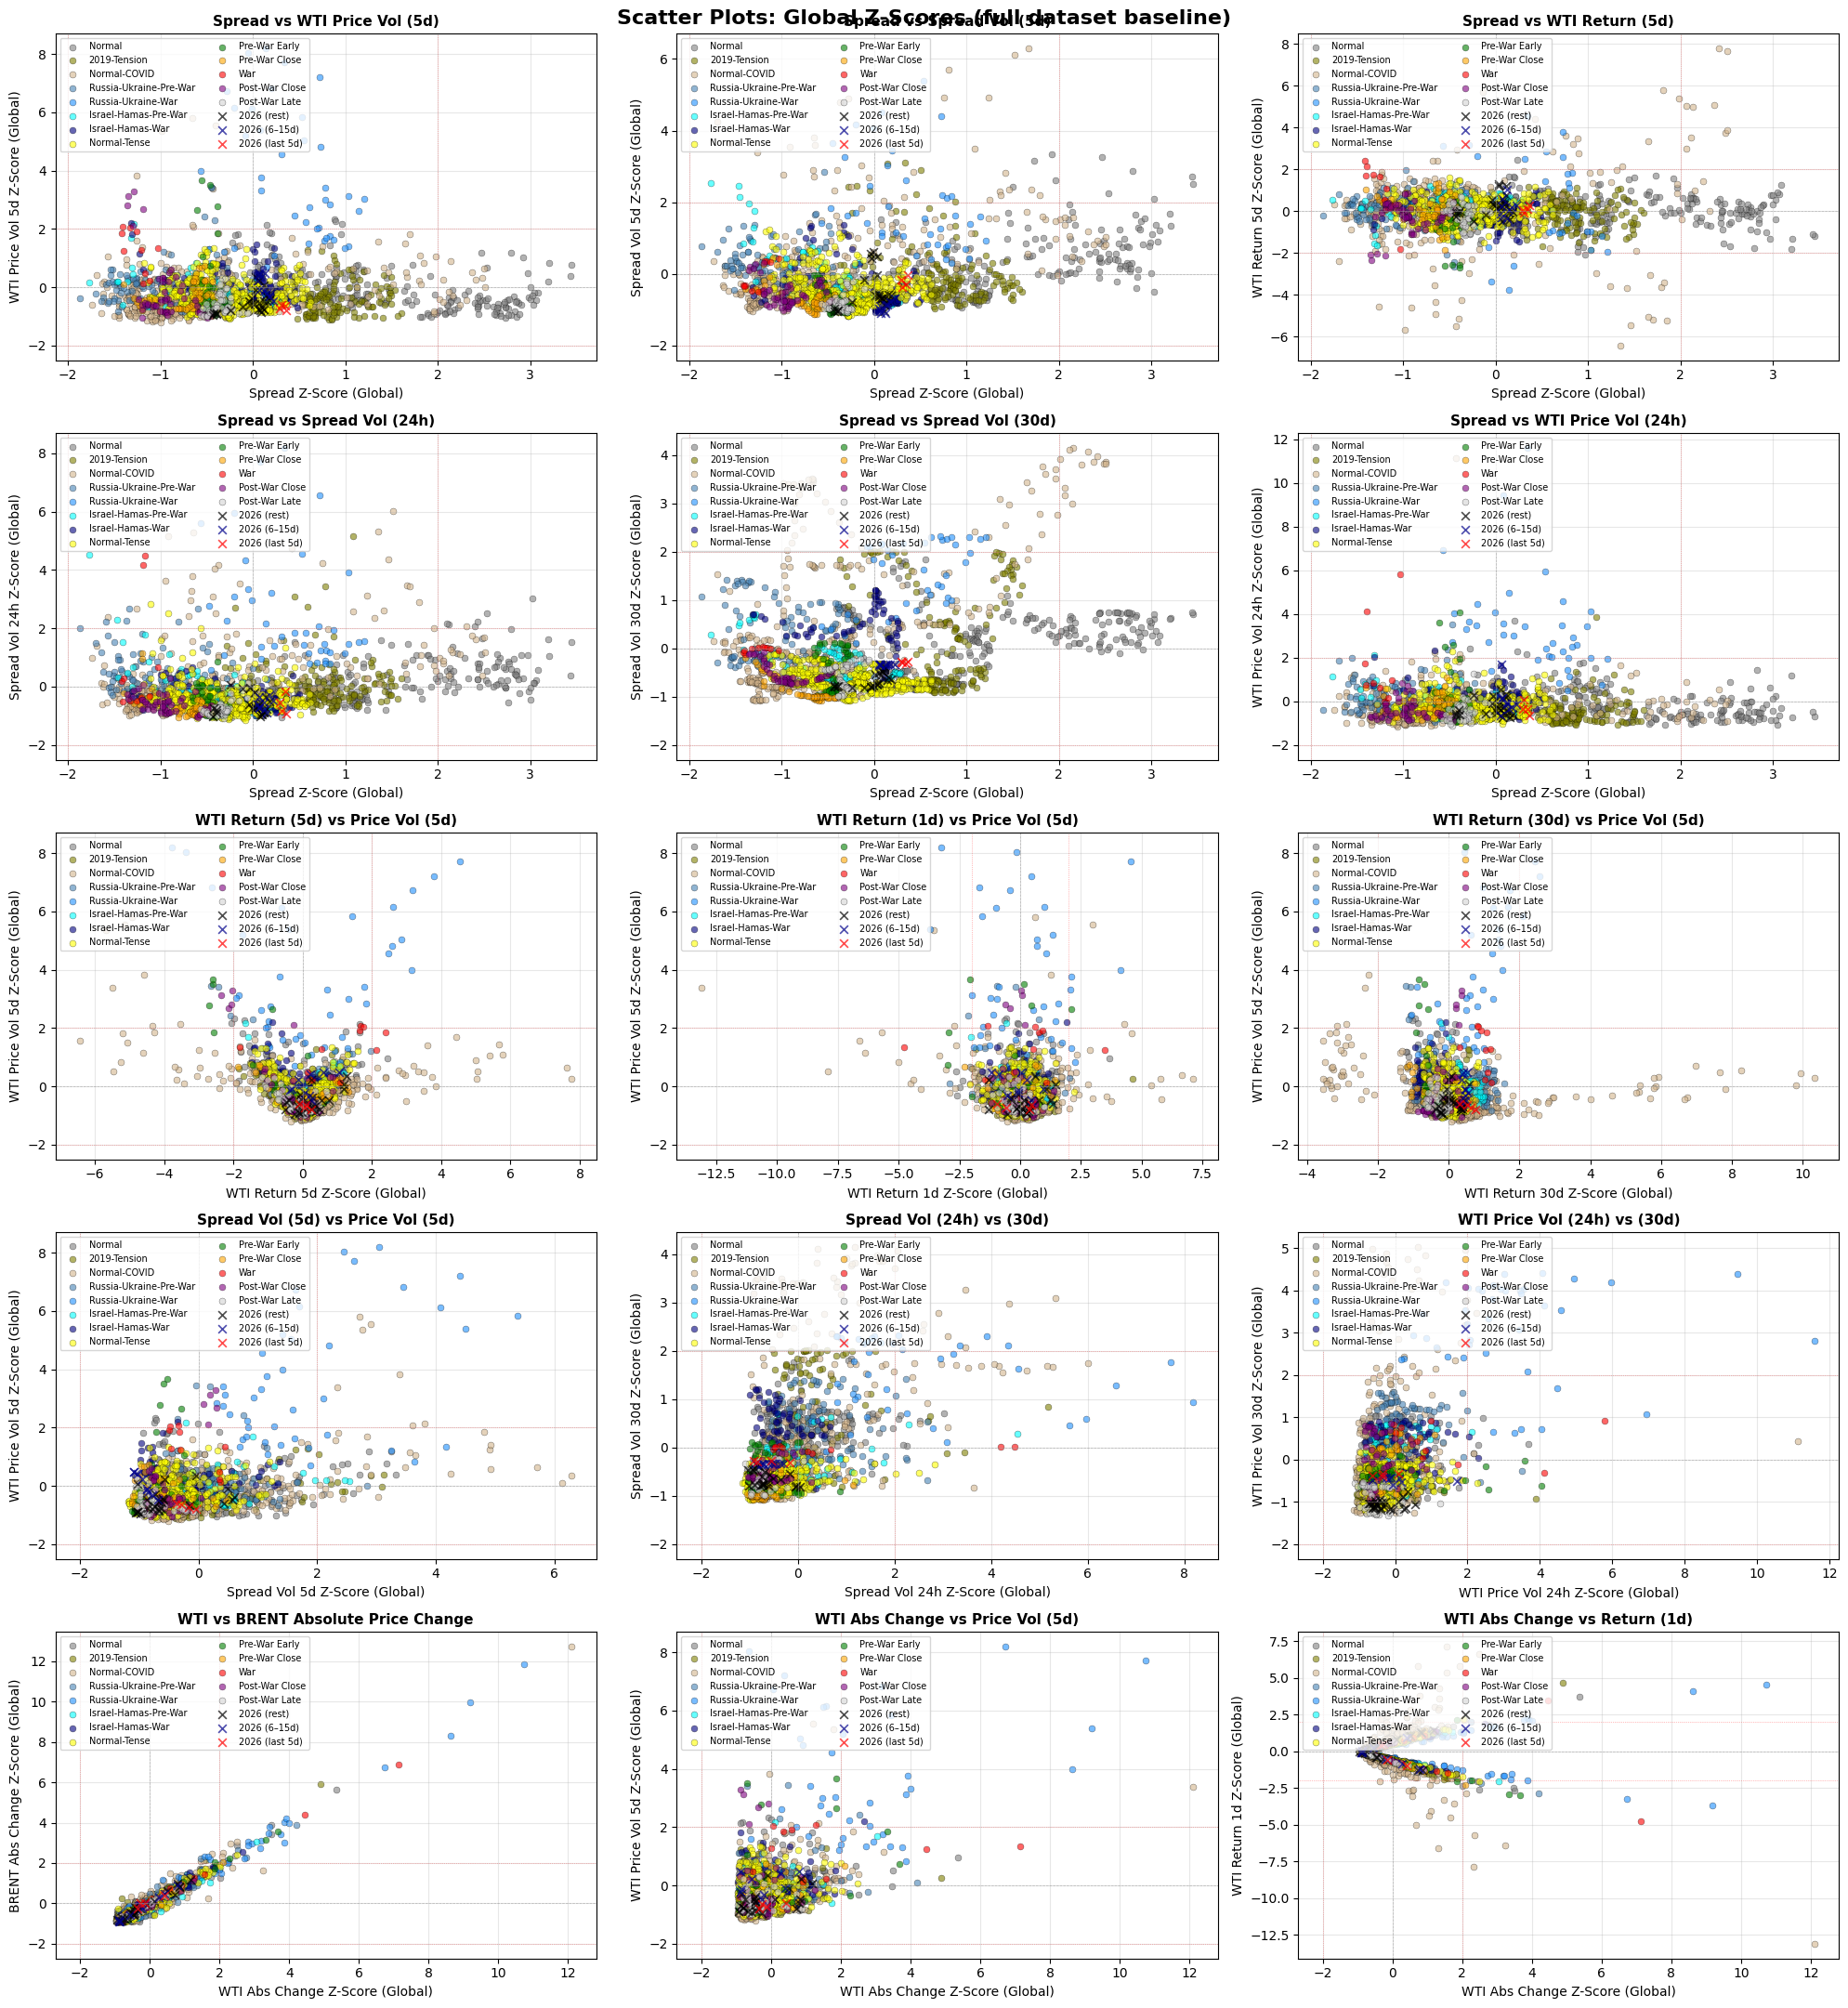


GLOBAL Z-SCORE SCATTER PLOTS COMPLETE
Note: ±2σ lines indicate extreme values (outside 95% confidence interval)
Global z-scores use the full dataset as baseline for comparison


In [9]:
# ============================================================================
# SCATTER PLOTS: GLOBAL Z-SCORES
# ============================================================================



# Split data into labeled (2024-2025) and unlabeled (2026+)
cutoff_date = pd.Timestamp('2026-01-01', tz='UTC')
df_labeled = df_final[df_final['date'] < cutoff_date].copy()
df_unlabeled = df_final[df_final['date'] >= cutoff_date].copy()
df_unlabeled = add_2026_segment_colors(df_unlabeled)

# Filter Russia-Ukraine-War to only show first 2 months (Feb 24 - Apr 24, 2022)
# This makes scatter plots cleaner by excluding later months that may be returning to normal
ru_war_start = pd.Timestamp('2022-02-24', tz='UTC')
ru_war_2month_end = pd.Timestamp('2022-04-24', tz='UTC')
mask_ru_war_later = (df_labeled['label'] == 'Russia-Ukraine-War') & \
                    (df_labeled['date'] > ru_war_2month_end)
df_labeled = df_labeled[~mask_ru_war_later].copy()

print(f"Labeled data (after filtering): {len(df_labeled)} points")
print(f"Unlabeled data (2026+): {len(df_unlabeled)} points")
print(f"Note: Russia-Ukraine-War filtered to first 2 months only (Feb 24 - Apr 24, 2022)")
print(f"{'='*80}")

# Create scatter plots for global z-score pairs - expanded grid
fig, axes = plt.subplots(5, 3, figsize=(20, 22))
fig.suptitle('Scatter Plots: Global Z-Scores (full dataset baseline)', fontsize=16, fontweight='bold')

# Helper function to create scatter plot with z-score reference lines
def create_zscore_scatter(ax, x_data, y_data, x_label, y_label, title):
    for label in df_labeled['label'].unique():
        mask = df_labeled['label'] == label
        ax.scatter(df_labeled.loc[mask, x_data], 
                  df_labeled.loc[mask, y_data],
                  c=label_colors.get(label, 'black'), 
                  label=label, alpha=0.6, s=25, edgecolors='black', linewidth=0.3)
    if len(df_unlabeled) > 0:
        for seg in ['rest', 'next_10', 'last_5']:
            mask = df_unlabeled['_2026_segment'] == seg
            if mask.any():
                ax.scatter(df_unlabeled.loc[mask, x_data], df_unlabeled.loc[mask, y_data],
                          c=UNLABELED_2026_COLORS[seg], marker='x', s=40, label=UNLABELED_2026_LABELS[seg], alpha=0.7, linewidth=1.2)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.axhline(y=2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.axhline(y=-2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.axvline(x=2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.axvline(x=-2, color='red', linestyle=':', alpha=0.5, linewidth=0.5)
    ax.set_xlabel(x_label, fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.legend(loc='upper left', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)

# Row 1: Spread z-scores vs various features
create_zscore_scatter(axes[0, 0], 'spread_zscore_global', 'WTI_price_vol_5d_zscore_global', 
                     'Spread Z-Score (Global)', 'WTI Price Vol 5d Z-Score (Global)', 'Spread vs WTI Price Vol (5d)')
create_zscore_scatter(axes[0, 1], 'spread_zscore_global', 'spread_vol_5d_zscore_global', 
                     'Spread Z-Score (Global)', 'Spread Vol 5d Z-Score (Global)', 'Spread vs Spread Vol (5d)')
create_zscore_scatter(axes[0, 2], 'spread_zscore_global', 'WTI_return_5d_zscore_global', 
                     'Spread Z-Score (Global)', 'WTI Return 5d Z-Score (Global)', 'Spread vs WTI Return (5d)')

# Row 2: Spread z-scores vs different timeframes
create_zscore_scatter(axes[1, 0], 'spread_zscore_global', 'spread_vol_24h_zscore_global', 
                     'Spread Z-Score (Global)', 'Spread Vol 24h Z-Score (Global)', 'Spread vs Spread Vol (24h)')
create_zscore_scatter(axes[1, 1], 'spread_zscore_global', 'spread_vol_30d_zscore_global', 
                     'Spread Z-Score (Global)', 'Spread Vol 30d Z-Score (Global)', 'Spread vs Spread Vol (30d)')
create_zscore_scatter(axes[1, 2], 'spread_zscore_global', 'WTI_price_vol_24h_zscore_global', 
                     'Spread Z-Score (Global)', 'WTI Price Vol 24h Z-Score (Global)', 'Spread vs WTI Price Vol (24h)')

# Row 3: Returns z-scores vs Volatilities z-scores
create_zscore_scatter(axes[2, 0], 'WTI_return_5d_zscore_global', 'WTI_price_vol_5d_zscore_global', 
                     'WTI Return 5d Z-Score (Global)', 'WTI Price Vol 5d Z-Score (Global)', 'WTI Return (5d) vs Price Vol (5d)')
create_zscore_scatter(axes[2, 1], 'WTI_return_1d_zscore_global', 'WTI_price_vol_5d_zscore_global', 
                     'WTI Return 1d Z-Score (Global)', 'WTI Price Vol 5d Z-Score (Global)', 'WTI Return (1d) vs Price Vol (5d)')
create_zscore_scatter(axes[2, 2], 'WTI_return_30d_zscore_global', 'WTI_price_vol_5d_zscore_global', 
                     'WTI Return 30d Z-Score (Global)', 'WTI Price Vol 5d Z-Score (Global)', 'WTI Return (30d) vs Price Vol (5d)')

# Row 4: Volatility z-score comparisons
create_zscore_scatter(axes[3, 0], 'spread_vol_5d_zscore_global', 'WTI_price_vol_5d_zscore_global', 
                     'Spread Vol 5d Z-Score (Global)', 'WTI Price Vol 5d Z-Score (Global)', 'Spread Vol (5d) vs Price Vol (5d)')
create_zscore_scatter(axes[3, 1], 'spread_vol_24h_zscore_global', 'spread_vol_30d_zscore_global', 
                     'Spread Vol 24h Z-Score (Global)', 'Spread Vol 30d Z-Score (Global)', 'Spread Vol (24h) vs (30d)')
create_zscore_scatter(axes[3, 2], 'WTI_price_vol_24h_zscore_global', 'WTI_price_vol_30d_zscore_global', 
                     'WTI Price Vol 24h Z-Score (Global)', 'WTI Price Vol 30d Z-Score (Global)', 'WTI Price Vol (24h) vs (30d)')

# Row 5: Absolute price change z-score comparisons
create_zscore_scatter(axes[4, 0], 'WTI_abs_change_zscore_global', 'BRENT_abs_change_zscore_global', 
                     'WTI Abs Change Z-Score (Global)', 'BRENT Abs Change Z-Score (Global)', 'WTI vs BRENT Absolute Price Change')
create_zscore_scatter(axes[4, 1], 'WTI_abs_change_zscore_global', 'WTI_price_vol_5d_zscore_global', 
                     'WTI Abs Change Z-Score (Global)', 'WTI Price Vol 5d Z-Score (Global)', 'WTI Abs Change vs Price Vol (5d)')
create_zscore_scatter(axes[4, 2], 'WTI_abs_change_zscore_global', 'WTI_return_1d_zscore_global', 
                     'WTI Abs Change Z-Score (Global)', 'WTI Return 1d Z-Score (Global)', 'WTI Abs Change vs Return (1d)')

plt.tight_layout()

# Save figure to images folder
images_dir = Path('images')
images_dir.mkdir(exist_ok=True)
fig.savefig(images_dir / 'data5.png', dpi=150, bbox_inches='tight')
print(f"\n💾 Saved visualization to {images_dir / 'data5.png'}")

plt.show()

print(f"\n{'='*80}")
print("GLOBAL Z-SCORE SCATTER PLOTS COMPLETE")
print(f"{'='*80}")
print("Note: ±2σ lines indicate extreme values (outside 95% confidence interval)")
print("Global z-scores use the full dataset as baseline for comparison")

PRINCIPAL COMPONENT ANALYSIS (PCA)

Using 12 global z-score features for PCA:
  - BRENT_abs_change_zscore_global
  - WTI_abs_change_zscore_global
  - WTI_price_vol_24h_zscore_global
  - WTI_price_vol_30d_zscore_global
  - WTI_price_vol_5d_zscore_global
  - WTI_return_1d_zscore_global
  - WTI_return_30d_zscore_global
  - WTI_return_5d_zscore_global
  - spread_vol_24h_zscore_global
  - spread_vol_30d_zscore_global
  - spread_vol_5d_zscore_global
  - spread_zscore_global

Data points: 1996 (removed 0 rows with NaN)

PCA RESULTS

Total variance explained by all components: 1.0000 (100.00%)

Top 5 Principal Components:
  PC1: 0.3864 (38.64%) - Cumulative: 0.3864 (38.64%)
  PC2: 0.1475 (14.75%) - Cumulative: 0.5339 (53.39%)
  PC3: 0.1281 (12.81%) - Cumulative: 0.6620 (66.20%)
  PC4: 0.0794 (7.94%) - Cumulative: 0.7415 (74.15%)
  PC5: 0.0673 (6.73%) - Cumulative: 0.8088 (80.88%)

Components needed for 90% variance: 7
Components needed for 95% variance: 9

💾 Saved visualization to images/data6

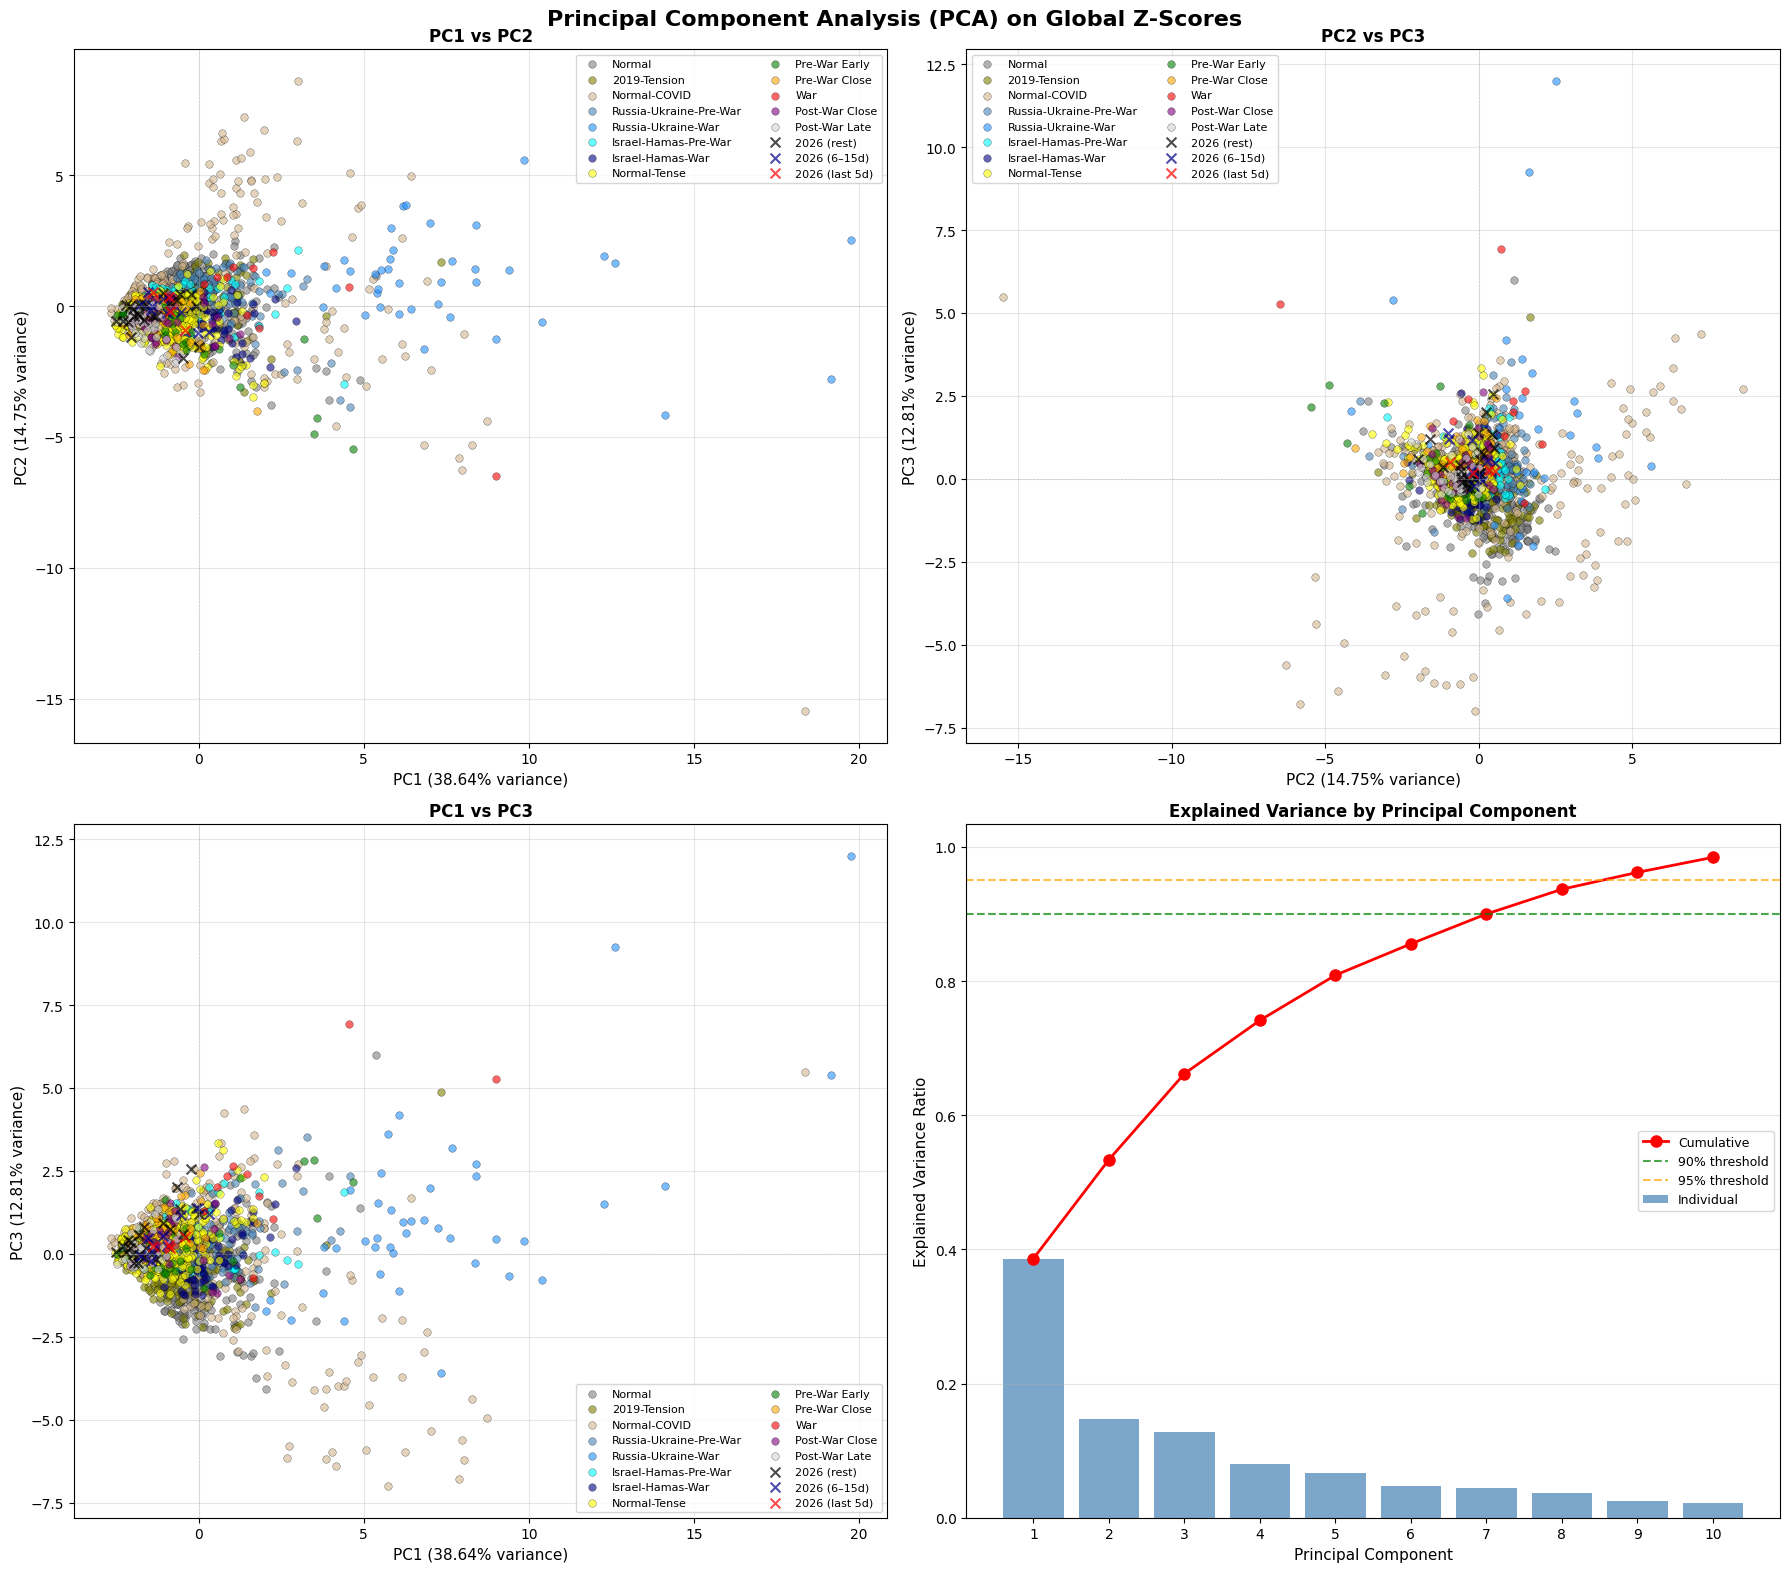


FEATURE LOADINGS (Top 3 Principal Components)

PC1 (Explains 38.64% of variance):
  WTI_price_vol_24h_zscore_global    :  0.3970
  WTI_abs_change_zscore_global       :  0.3657
  BRENT_abs_change_zscore_global     :  0.3644
  spread_vol_24h_zscore_global       :  0.3570
  WTI_price_vol_5d_zscore_global     :  0.3522

PC2 (Explains 14.75% of variance):
  WTI_return_5d_zscore_global        :  0.5373
  WTI_return_1d_zscore_global        :  0.4954
  WTI_return_30d_zscore_global       :  0.3768
  spread_vol_30d_zscore_global       :  0.3226
  spread_vol_5d_zscore_global        :  0.2047

PC3 (Explains 12.81% of variance):
  WTI_abs_change_zscore_global       :  0.3846
  BRENT_abs_change_zscore_global     :  0.3845
  WTI_return_30d_zscore_global       :  0.3705
  WTI_return_5d_zscore_global        :  0.3405
  spread_zscore_global               : -0.3354

PCA COMPLETE

PCA coordinates saved in X_pca (shape: (1996, 12))
Use these coordinates for dimensionality reduction or visualization


In [10]:
# ============================================================================
# PRINCIPAL COMPONENT ANALYSIS (PCA) ON GLOBAL Z-SCORES
# ============================================================================

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("="*80)
print("PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("="*80)

# Get global z-score features (exclude metadata columns)
zscore_global_features = [col for col in df_final.columns if col.endswith('_zscore_global')]
print(f"\nUsing {len(zscore_global_features)} global z-score features for PCA:")
for feat in sorted(zscore_global_features):
    print(f"  - {feat}")

# Prepare data (remove NaN if any)
X_zscore = df_final[zscore_global_features].values
valid_mask = ~np.isnan(X_zscore).any(axis=1)
X_zscore_clean = X_zscore[valid_mask]
df_pca = df_final[valid_mask].copy()

print(f"\nData points: {len(X_zscore_clean)} (removed {len(df_final) - len(X_zscore_clean)} rows with NaN)")

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_zscore_clean)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n{'='*80}")
print("PCA RESULTS")
print(f"{'='*80}")
print(f"\nTotal variance explained by all components: {cumulative_variance[-1]:.4f} ({cumulative_variance[-1]*100:.2f}%)")
print(f"\nTop 5 Principal Components:")
for i in range(min(5, len(explained_variance))):
    print(f"  PC{i+1}: {explained_variance[i]:.4f} ({explained_variance[i]*100:.2f}%) - Cumulative: {cumulative_variance[i]:.4f} ({cumulative_variance[i]*100:.2f}%)")

# Find number of components for 90% and 95% variance
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nComponents needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")

# ============================================================================
# VISUALIZE PCA RESULTS
# ============================================================================



# Split data into labeled (2024-2025) and unlabeled (2026+)
cutoff_date = pd.Timestamp('2026-01-01', tz='UTC')
df_labeled_pca = df_pca[df_pca['date'] < cutoff_date].copy()
df_unlabeled_pca = df_pca[df_pca['date'] >= cutoff_date].copy()
df_unlabeled_pca = add_2026_segment_colors(df_unlabeled_pca)

# Get PCA coordinates for labeled and unlabeled data (before filtering)
X_pca_labeled_full = X_pca[df_pca['date'] < cutoff_date]
X_pca_unlabeled = X_pca[df_pca['date'] >= cutoff_date]

# Filter Russia-Ukraine-War to only show first 2 months (Feb 24 - Apr 24, 2022)
# This makes scatter plots cleaner by excluding later months that may be returning to normal
ru_war_start = pd.Timestamp('2022-02-24', tz='UTC')
ru_war_2month_end = pd.Timestamp('2022-04-24', tz='UTC')

# Create a temporary dataframe with the same index as X_pca_labeled_full for filtering
df_labeled_pca_temp = df_pca[df_pca['date'] < cutoff_date].copy()
mask_ru_war_later = (df_labeled_pca_temp['label'] == 'Russia-Ukraine-War') & \
                    (df_labeled_pca_temp['date'] > ru_war_2month_end)

# Apply the same filter to both df_labeled_pca and X_pca_labeled
df_labeled_pca = df_labeled_pca_temp[~mask_ru_war_later].copy()
X_pca_labeled = X_pca_labeled_full[~mask_ru_war_later]

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('Principal Component Analysis (PCA) on Global Z-Scores', fontsize=16, fontweight='bold')

# Plot 1: PC1 vs PC2
ax = axes[0, 0]
for label in df_labeled_pca['label'].unique():
    mask = df_labeled_pca['label'] == label
    ax.scatter(X_pca_labeled[mask, 0], X_pca_labeled[mask, 1],
              c=label_colors.get(label, 'black'), 
              label=label, alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
if len(df_unlabeled_pca) > 0:
    for seg in ['rest', 'next_10', 'last_5']:
        mask = df_unlabeled_pca['_2026_segment'] == seg
        if mask.any():
            ax.scatter(X_pca_unlabeled[mask.values, 0], X_pca_unlabeled[mask.values, 1],
                      c=UNLABELED_2026_COLORS[seg], marker='x', s=50, label=UNLABELED_2026_LABELS[seg], alpha=0.7, linewidth=1.5)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}% variance)', fontsize=11)
ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.2f}% variance)', fontsize=11)
ax.set_title('PC1 vs PC2', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)

# Plot 2: PC2 vs PC3
ax = axes[0, 1]
for label in df_labeled_pca['label'].unique():
    mask = df_labeled_pca['label'] == label
    ax.scatter(X_pca_labeled[mask, 1], X_pca_labeled[mask, 2],
              c=label_colors.get(label, 'black'), 
              label=label, alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
if len(df_unlabeled_pca) > 0:
    for seg in ['rest', 'next_10', 'last_5']:
        mask = df_unlabeled_pca['_2026_segment'] == seg
        if mask.any():
            ax.scatter(X_pca_unlabeled[mask.values, 1], X_pca_unlabeled[mask.values, 2],
                      c=UNLABELED_2026_COLORS[seg], marker='x', s=50, label=UNLABELED_2026_LABELS[seg], alpha=0.7, linewidth=1.5)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
ax.set_xlabel(f'PC2 ({explained_variance[1]*100:.2f}% variance)', fontsize=11)
ax.set_ylabel(f'PC3 ({explained_variance[2]*100:.2f}% variance)', fontsize=11)
ax.set_title('PC2 vs PC3', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)

# Plot 3: PC1 vs PC3
ax = axes[1, 0]
for label in df_labeled_pca['label'].unique():
    mask = df_labeled_pca['label'] == label
    ax.scatter(X_pca_labeled[mask, 0], X_pca_labeled[mask, 2],
              c=label_colors.get(label, 'black'), 
              label=label, alpha=0.6, s=30, edgecolors='black', linewidth=0.3)
if len(df_unlabeled_pca) > 0:
    for seg in ['rest', 'next_10', 'last_5']:
        mask = df_unlabeled_pca['_2026_segment'] == seg
        if mask.any():
            ax.scatter(X_pca_unlabeled[mask.values, 0], X_pca_unlabeled[mask.values, 2],
                      c=UNLABELED_2026_COLORS[seg], marker='x', s=50, label=UNLABELED_2026_LABELS[seg], alpha=0.7, linewidth=1.5)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)
ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.2f}% variance)', fontsize=11)
ax.set_ylabel(f'PC3 ({explained_variance[2]*100:.2f}% variance)', fontsize=11)
ax.set_title('PC1 vs PC3', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)

# Plot 4: Explained Variance
ax = axes[1, 1]
n_components_plot = min(10, len(explained_variance))
x_pos = np.arange(1, n_components_plot + 1)
ax.bar(x_pos, explained_variance[:n_components_plot], alpha=0.7, color='steelblue', label='Individual')
ax.plot(x_pos, cumulative_variance[:n_components_plot], 'ro-', linewidth=2, markersize=8, label='Cumulative')
ax.axhline(y=0.90, color='green', linestyle='--', alpha=0.7, label='90% threshold')
ax.axhline(y=0.95, color='orange', linestyle='--', alpha=0.7, label='95% threshold')
ax.set_xlabel('Principal Component', fontsize=11)
ax.set_ylabel('Explained Variance Ratio', fontsize=11)
ax.set_title('Explained Variance by Principal Component', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(x_pos)

plt.tight_layout()

# Save figure to images folder
images_dir = Path('images')
images_dir.mkdir(exist_ok=True)
fig.savefig(images_dir / 'data6.png', dpi=150, bbox_inches='tight')
print(f"\n💾 Saved visualization to {images_dir / 'data6.png'}")

plt.show()

# Display feature loadings for top components
print(f"\n{'='*80}")
print("FEATURE LOADINGS (Top 3 Principal Components)")
print(f"{'='*80}")
for i in range(min(3, len(explained_variance))):
    print(f"\nPC{i+1} (Explains {explained_variance[i]*100:.2f}% of variance):")
    loadings = pca.components_[i]
    # Get top 5 features with highest absolute loadings
    top_indices = np.argsort(np.abs(loadings))[-5:][::-1]
    for idx in top_indices:
        feat_name = zscore_global_features[idx]
        loading_val = loadings[idx]
        print(f"  {feat_name:35s}: {loading_val:7.4f}")

print(f"\n{'='*80}")
print("PCA COMPLETE")
print(f"{'='*80}")
print(f"\nPCA coordinates saved in X_pca (shape: {X_pca.shape})")
print(f"Use these coordinates for dimensionality reduction or visualization")

In [11]:
# ============================================================================
# SAVE PROCESSED DATA FOR USE IN OTHER NOTEBOOKS
# ============================================================================

print("="*80)
print("SAVING PROCESSED DATA")
print("="*80)

# Ensure output directory exists
output_dir = Path('data')
output_dir.mkdir(exist_ok=True)

# Save the final dataframe with all features, z-scores, and labels
output_file = output_dir / 'processed_features_with_labels.csv'

# Reset index to make date a regular column (easier to load in other notebooks)
df_final_save = df_final.reset_index(drop=True)

# Identify feature columns for summary
raw_features = [col for col in df_final_save.columns if not col.endswith('_zscore_rolling') and not col.endswith('_zscore_global') and col not in ['date', 'WTI_price', 'BRENT_price', 'label']]
rolling_z = [col for col in df_final_save.columns if col.endswith('_zscore_rolling')]
global_z = [col for col in df_final_save.columns if col.endswith('_zscore_global')]

# Save to CSV
df_final_save.to_csv(output_file, index=False)
print(f"✅ Saved processed data to: {output_file}")
print(f"   Shape: {df_final_save.shape}")
print(f"   Columns: {len(df_final_save.columns)}")

# Also save a summary of what's included
summary_file = output_dir / 'processed_data_summary.txt'
with open(summary_file, 'w') as f:
    f.write("="*80 + "\n")
    f.write("PROCESSED DATA SUMMARY\n")
    f.write("="*80 + "\n\n")
    f.write(f"File: {output_file}\n")
    f.write(f"Shape: {df_final_save.shape[0]} rows × {df_final_save.shape[1]} columns\n")
    f.write(f"Date range: {df_final_save['date'].min()} to {df_final_save['date'].max()}\n\n")
    
    f.write("COLUMNS INCLUDED:\n")
    f.write("-" * 80 + "\n")
    f.write("Metadata:\n")
    f.write("  - date: Timestamp\n")
    f.write("  - WTI_price: WTI crude oil price (USD)\n")
    f.write("  - BRENT_price: Brent crude oil price (USD)\n")
    f.write("  - label: Geopolitical period label\n\n")
    
    f.write(f"Raw Features ({len(raw_features)}):\n")
    for feat in sorted(raw_features):
        f.write(f"  - {feat}\n")
    
    f.write(f"\nRolling Z-Scores ({len(rolling_z)}):\n")
    for feat in sorted(rolling_z):
        f.write(f"  - {feat}\n")
    
    f.write(f"\nGlobal Z-Scores ({len(global_z)}):\n")
    for feat in sorted(global_z):
        f.write(f"  - {feat}\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write("LABEL DISTRIBUTION:\n")
    f.write("-" * 80 + "\n")
    label_counts = df_final_save['label'].value_counts().sort_index()
    for label, count in label_counts.items():
        pct = count / len(df_final_save) * 100
        f.write(f"  {label:20s}: {count:6d} ({pct:5.2f}%)\n")
    
    f.write("\n" + "="*80 + "\n")
    f.write("USAGE IN OTHER NOTEBOOKS:\n")
    f.write("-" * 80 + "\n")
    f.write("import pandas as pd\n")
    f.write("from pathlib import Path\n\n")
    f.write("df = pd.read_csv('data/processed_features_with_labels.csv', parse_dates=['date'])\n")
    f.write("\n# Access features:\n")
    f.write("# Raw features: df[['spread', 'spread_vol_5d', 'WTI_return_5d', ...]]\n")
    f.write("# Rolling z-scores: df[['spread_zscore_rolling', ...]]\n")
    f.write("# Global z-scores: df[['spread_zscore_global', ...]]\n")
    f.write("# Labels: df['label']\n")

print(f"✅ Saved data summary to: {summary_file}")

# Display column information
print(f"\n{'='*80}")
print("DATA STRUCTURE")
print(f"{'='*80}")
print(f"\nTotal columns: {len(df_final_save.columns)}")
print(f"  - Metadata: 4 columns (date, WTI_price, BRENT_price, label)")
print(f"  - Raw features: {len(raw_features)} columns")
print(f"  - Rolling z-scores: {len(rolling_z)} columns")
print(f"  - Global z-scores: {len(global_z)} columns")

print(f"\n{'='*80}")
print("DATA SAVED SUCCESSFULLY")
print(f"{'='*80}")
print(f"\nFiles created:")
print(f"  1. {output_file}")
print(f"  2. {summary_file}")
print(f"\nYou can now load this data in other notebooks for model training!")
print(f"\nExample usage:")
print(f"  import pandas as pd")
print(f"  df = pd.read_csv('{output_file}', parse_dates=['date'])")

SAVING PROCESSED DATA
✅ Saved processed data to: data/processed_features_with_labels.csv
   Shape: (1996, 40)
   Columns: 40
✅ Saved data summary to: data/processed_data_summary.txt

DATA STRUCTURE

Total columns: 40
  - Metadata: 4 columns (date, WTI_price, BRENT_price, label)
  - Raw features: 12 columns
  - Rolling z-scores: 12 columns
  - Global z-scores: 12 columns

DATA SAVED SUCCESSFULLY

Files created:
  1. data/processed_features_with_labels.csv
  2. data/processed_data_summary.txt

You can now load this data in other notebooks for model training!

Example usage:
  import pandas as pd
  df = pd.read_csv('data/processed_features_with_labels.csv', parse_dates=['date'])
